In [ ]:
# Cell 1: Install Required Packages

!pip install gensim
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

: 

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import scipy.sparse

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.optimizers import Adam

import gensim
from gensim.models import Word2Vec
import pickle
import gc
import os

In [ ]:
# Cell 3: Load Training and Test Datasets
# This cell loads the training and test CSV files from Google Drive.

train_file_path = '/content/drive/MyDrive/CSE440_Project/Question Answer Classification Dataset 1[Training].csv'
test_file_path = '/content/drive/MyDrive/CSE440_Project/[Updated] Question Answer Classification Dataset[Test].csv'

df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

print(f"Training dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")
print("Training dataset head:\n", df_train.head())
print("Test dataset head:\n", df_test.head())


gc.collect()

# **EDA**

In [ ]:
df_test.head(10)

In [ ]:
df_train.head(10)


In [ ]:
df_train.isnull().sum()

In [ ]:
df_test.isnull().sum()

In [ ]:
df_test['Class'].value_counts()

In [ ]:
df_test['Class'].value_counts()

In [ ]:
class_counts = df_train['Class'].value_counts()

plt.figure(figsize=(15, 5))
class_counts.plot(kind='bar', edgecolor='black')

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
class_counts = df_test['Class'].value_counts()

plt.figure(figsize=(15, 5))
class_counts.plot(kind='bar', edgecolor='black')

plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

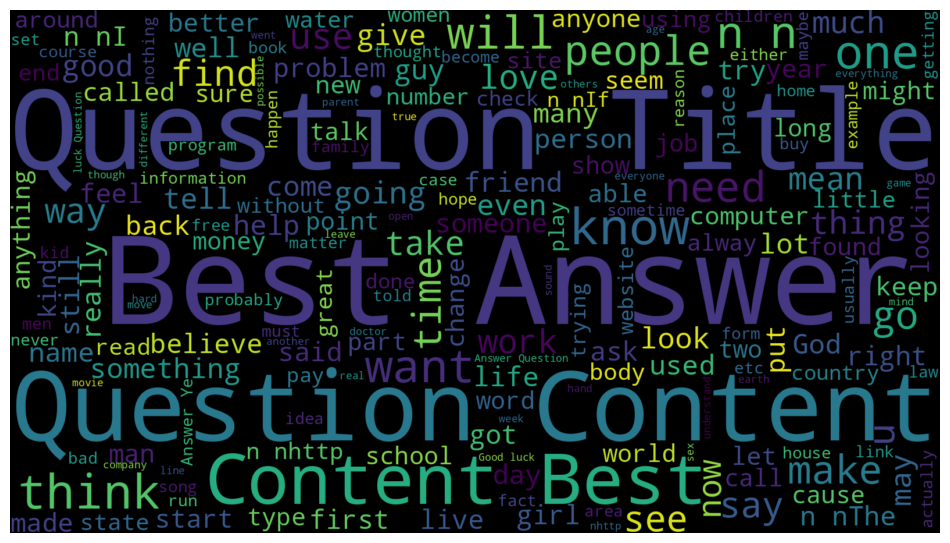

In [79]:
from wordcloud import WordCloud

text = " ".join(df_train["QA Text"].astype(str))

wordcloud = WordCloud(width=1600, height=900, background_color='black').generate(text)

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [4]:
df_train['text_length'] = df_train['QA Text'].apply(len)
df_train['word_count'] = df_train['QA Text'].apply(lambda x: len(x.split()))

df_test['text_length'] = df_test['QA Text'].apply(len)
df_test['word_count'] = df_test['QA Text'].apply(lambda x: len(x.split()))

print("Training Data - Text Length and Word Count Statistics:")
print(df_train[['text_length', 'word_count']].describe())

print("\nTesting Data - Text Length and Word Count Statistics:")
print(df_test[['text_length', 'word_count']].describe())

Training Data - Text Length and Word Count Statistics:
         text_length     word_count
count  279999.000000  279999.000000
mean      568.684935      97.725510
std       578.380007      98.791204
min        59.000000       7.000000
25%       223.000000      37.000000
50%       387.000000      66.000000
75%       688.000000     120.000000
max      8031.000000    1382.000000

Testing Data - Text Length and Word Count Statistics:
        text_length    word_count
count  59999.000000  59999.000000
mean     568.945766     97.731479
std      581.321546     99.236394
min       61.000000      7.000000
25%      221.000000     37.000000
50%      386.000000     66.000000
75%      686.000000    120.000000
max     5867.000000   1027.000000


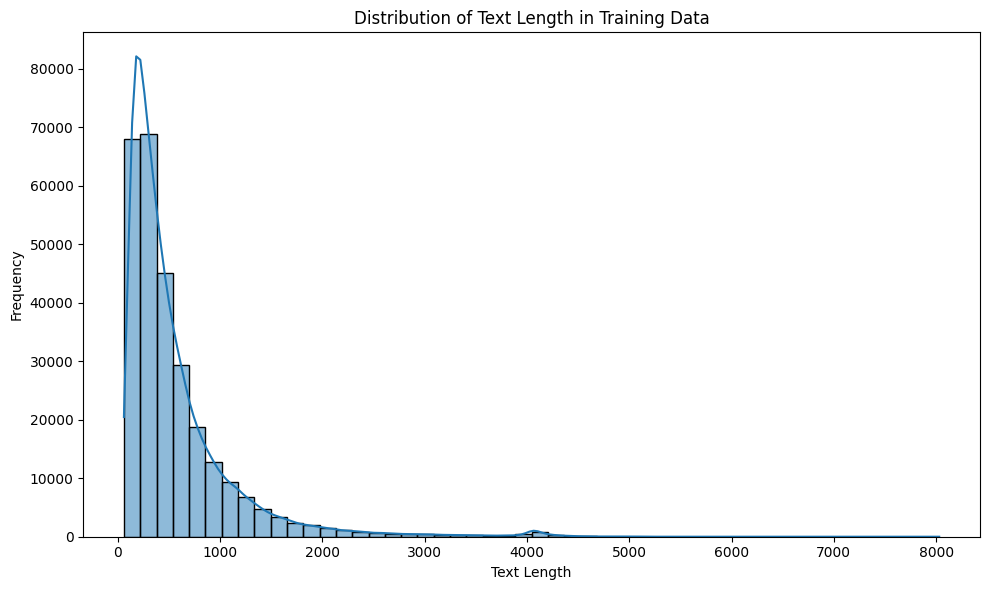

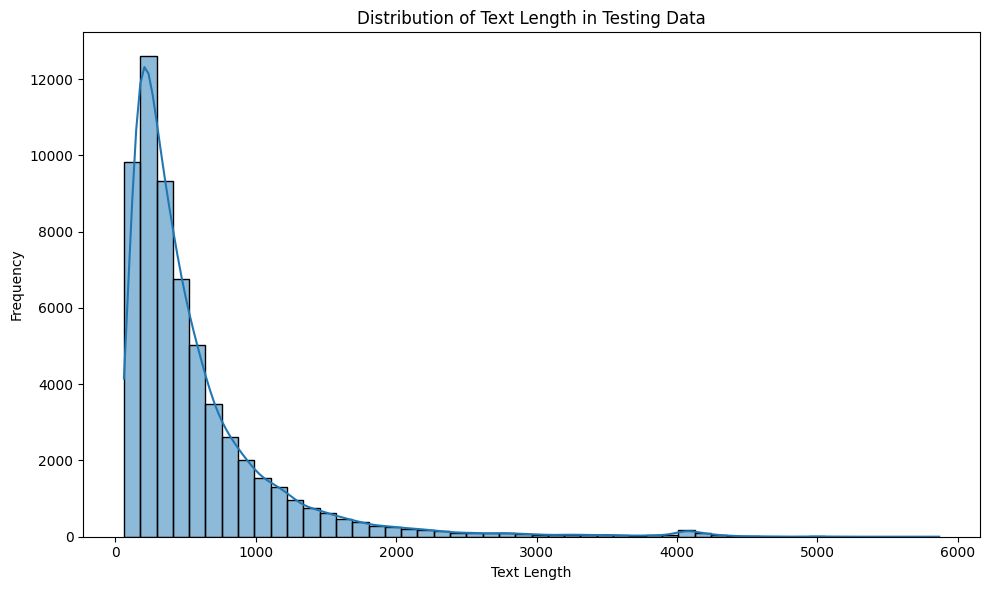

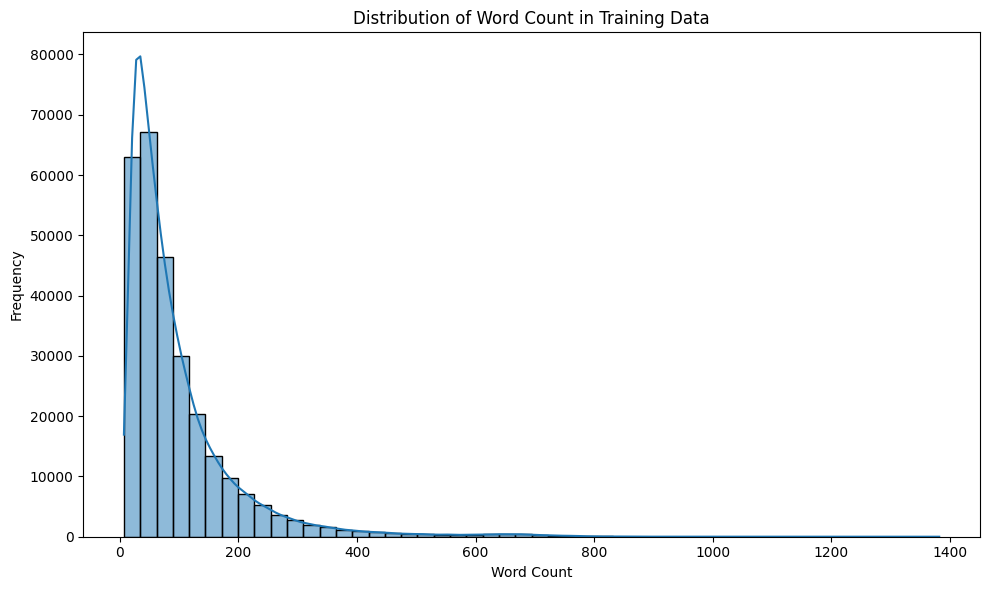

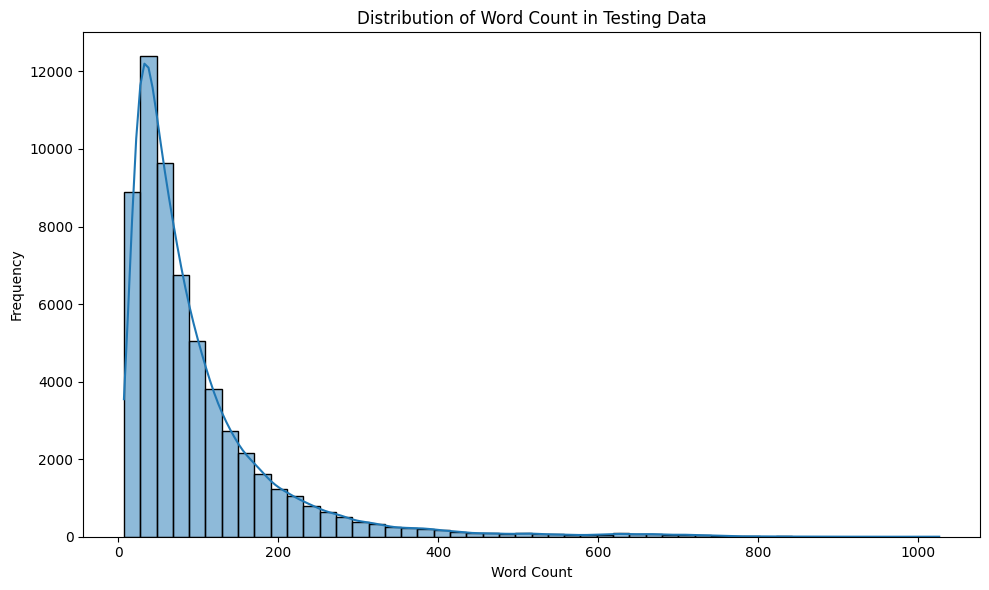

In [6]:



plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], bins=50, kde=True)
plt.title("Distribution of Text Length in Training Data")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_test['text_length'], bins=50, kde=True)
plt.title("Distribution of Text Length in Testing Data")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_train['word_count'], bins=50, kde=True)
plt.title("Distribution of Word Count in Training Data")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_test['word_count'], bins=50, kde=True)
plt.title("Distribution of Word Count in Testing Data")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [13]:
df_train.drop(['text_length', 'word_count'], axis=1, inplace=True)
df_test.drop(['text_length', 'word_count'], axis=1, inplace=True)

print("Temporary columns 'text_length' and 'word_count' have been removed from training and test datasets.")
gc.collect()

Temporary columns 'text_length' and 'word_count' have been removed from training and test datasets.


12042

In [15]:
df_train.head(5)

,QA Text,Class
0,Question Title:\nHave you liked a person who i...,Family & Relationships
1,Question Title:\nwhat is simulation?\nQuestion...,Science & Mathematics
2,Question Title:\nhelp to loose weight?\nQuest...,Health
3,Question Title:\nDid you know that the KKK ado...,Business & Finance
4,Question Title:\nhow can i find an old friend ...,Family & Relationships


In [16]:
df_test.head(5)

,QA Text,Class
0,Question Title:\nWhy does Zebras have stripes?...,Science & Mathematics
1,Question Title:\nWhat did the itsy bitsy sipde...,Education & Reference
2,Question Title:\nWhat is the difference betwee...,Education & Reference
3,Question Title:\nWhy do women get PMS?\nQuesti...,Health
4,Question Title:\nIf your co-worker is guilty o...,Health


# **PREPROCESSING**

**Pre-processing(Training dataset)**

In [4]:
# Cell 4: Preprocessing - Lowercase Conversion (Training)
# This cell converts text to lowercase for the training dataset.
df_train['QA Text'] = df_train['QA Text'].str.lower()
print("Lowercase conversion completed for training data.")
print("Sample:\n", df_train['QA Text'].head())
gc.collect()

Lowercase conversion completed for training data.
Sample:
 0    question title:\nhave you liked a person who i...
1    question title:\nwhat is simulation?\nquestion...
2    question title:\nhelp to  loose weight?\nquest...
3    question title:\ndid you know that the kkk ado...
4    question title:\nhow can i find an old friend ...
Name: QA Text, dtype: object


13

In [5]:
# Cell 5: Preprocessing - Punctuation Removal (Training)
# This cell removes punctuation and special characters from training text.
df_train['QA Text'] = df_train['QA Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
print("Punctuation removal completed for training data.")
print("Sample:\n", df_train['QA Text'].head())
gc.collect()

Punctuation removal completed for training data.
Sample:
 0    question title\nhave you liked a person who is...
1    question title\nwhat is simulation\nquestion c...
2    question title\nhelp to  loose weight\nquestio...
3    question title\ndid you know that the kkk adop...
4    question title\nhow can i find an old friend i...
Name: QA Text, dtype: object


0

In [ ]:
# Cell 6: Preprocessing - Whitespace Normalization (Training) whitespace (space, tab, newline \n, etc.).
# This cell normalizes whitespace in training text.
df_train['QA Text'] = df_train['QA Text'].apply(lambda x: ' '.join(x.split()))
print("Whitespace normalization completed for training data.")
print("Sample:\n", df_train['QA Text'].head())
gc.collect()

Whitespace normalization completed for training data.
Sample:
 0    question title have you liked a person who is ...
1    question title what is simulation question con...
2    question title help to loose weight question c...
3    question title did you know that the kkk adopt...
4    question title how can i find an old friend in...
Name: QA Text, dtype: object


0

In [7]:
# Cell 7: Preprocessing - Tokenization and Stopword Removal (Training)
# This cell tokenizes the text and removes stopwords for training data.
stop_words = set(stopwords.words('english'))
df_train['tokens'] = df_train['QA Text'].apply(word_tokenize)
df_train['tokens'] = df_train['tokens'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])
print("Tokenization and stopword removal completed for training data.")
print("Sample tokens:\n", df_train['tokens'].head())
gc.collect()

Tokenization and stopword removal completed for training data.
Sample tokens:
 0    [question, title, liked, person, bisexual, cou...
1    [question, title, simulation, question, conten...
2    [question, title, help, loose, weight, questio...
3    [question, title, know, kkk, adopted, highway,...
4    [question, title, find, old, friend, uk, quest...
Name: tokens, dtype: object


0

In [12]:
# Cell 8: Preprocessing - Lemmatization (Training)
# This cell applies lemmatization without POS tagging to training tokens for faster processing.
lemmatizer = WordNetLemmatizer()

df_train['tokens'] = df_train['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
print("Lemmatization completed for training data.")
print("Sample lemmatized tokens:\n", df_train['tokens'].head())
gc.collect()

Lemmatization completed for training data.
Sample lemmatized tokens:
 0    [question, title, liked, person, bisexual, cou...
1    [question, title, simulation, question, conten...
2    [question, title, help, loose, weight, questio...
3    [question, title, know, kkk, adopted, highway,...
4    [question, title, find, old, friend, uk, quest...
Name: tokens, dtype: object


0

In [ ]:
# Cell 9: Preprocessing - Label Encoding (Training)
# This cell encodes the class labels for training data.
label_encoder = LabelEncoder()
df_train['Class_encoded'] = label_encoder.fit_transform(df_train['Class'])
print("Label encoding completed for training data.")
print("Unique classes:", label_encoder.classes_)
print("Sample encoded labels:\n", df_train[['Class', 'Class_encoded']].head())
num_classes = len(label_encoder.classes_)
gc.collect() # gc = Python’s garbage collector module.

Label encoding completed for training data.
Unique classes: ['Business & Finance' 'Computers & Internet' 'Education & Reference'
 'Entertainment & Music' 'Family & Relationships' 'Health'
 'Politics & Government' 'Science & Mathematics' 'Society & Culture'
 'Sports']
Sample encoded labels:
                     Class  Class_encoded
0  Family & Relationships              4
1   Science & Mathematics              7
2                  Health              5
3      Business & Finance              0
4  Family & Relationships              4


0

**Pre-processing(Test dataset)**

In [14]:
# Cell 10: Apply Preprocessing to Test Dataset (Lowercase, Punctuation, Whitespace)
# This cell applies the same preprocessing steps to the test dataset (without fitting new encoders).
df_test['QA Text'] = df_test['QA Text'].str.lower()
df_test['QA Text'] = df_test['QA Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_test['QA Text'] = df_test['QA Text'].apply(lambda x: ' '.join(x.split()))
print("Basic preprocessing completed for test data.")
gc.collect()

Basic preprocessing completed for test data.


13

In [15]:
# Cell 11: Tokenization and Stopword Removal (Test)
# This cell tokenizes and removes stopwords from test data.
df_test['tokens'] = df_test['QA Text'].apply(word_tokenize)
df_test['tokens'] = df_test['tokens'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])
print("Tokenization and stopword removal completed for test data.")
gc.collect()

Tokenization and stopword removal completed for test data.


0

In [17]:
# Cell 12: Lemmatization (Test)

lemmatizer = WordNetLemmatizer()

df_test['tokens'] = df_test['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
print("Lemmatization completed for test data.")
gc.collect()

Lemmatization completed for test data.


358

In [18]:
# Cell 13: Label Encoding (Test)
# This cell encodes test labels using the fitted label encoder from training.
df_test['Class_encoded'] = label_encoder.transform(df_test['Class'])
print("Label encoding completed for test data.")
print("Sample encoded test labels:\n", df_test[['Class', 'Class_encoded']].head())
gc.collect()

Label encoding completed for test data.
Sample encoded test labels:
                    Class  Class_encoded
0  Science & Mathematics              7
1  Education & Reference              2
2  Education & Reference              2
3                 Health              5
4                 Health              5


0

In [19]:
# Cell 14: Data Preparation - Train/Test Split and Subsampling for Memory Efficiency
# This cell prepares X and y for train/test, with subsampling for memory efficiency (50% of original train for initial experiments).
# No split needed since datasets are separate; subsample train to fit RAM.
df_train_sub = df_train.sample(frac=0.5, random_state=42)  # Subsample 50% of train for memory
X_text_train = df_train_sub['QA Text']  # Use processed text for vectorizers
X_tokens_train = df_train_sub['tokens']
y_train = df_train_sub['Class_encoded']

X_text_test = df_test['QA Text']
X_tokens_test = df_test['tokens']
y_test = df_test['Class_encoded']

print(f"Subsampled train shape: {len(y_train)}")
print(f"Test shape: {len(y_test)}")

# Create processed text for token-based representations
df_train_sub['processed_text'] = df_train_sub['tokens'].apply(lambda x: ' '.join(x))
df_test['processed_text'] = df_test['tokens'].apply(lambda x: ' '.join(x))

# Clear original dataframes to save memory
del df_train, df_test, df_train_sub
gc.collect()

Subsampled train shape: 140000
Test shape: 59999


0

**Preparing data for different models**

In [21]:
# Cell 15: Tokenizer Setup for Sequence Models
# This cell sets up the tokenizer for padding sequences in neural models (fit on train, transform test).
# Reduced vocab and sequence length for memory efficiency.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

MAX_NUM_WORDS = 10000  # Reduced vocab size
MAX_SEQUENCE_LENGTH = 100  # Reduced sequence length

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_text_train)
word_index = tokenizer.word_index

X_seq_train = tokenizer.texts_to_sequences(X_text_train)
X_seq_test = tokenizer.texts_to_sequences(X_text_test)

X_pad_train = pad_sequences(X_seq_train, maxlen=MAX_SEQUENCE_LENGTH)
X_pad_test = pad_sequences(X_seq_test, maxlen=MAX_SEQUENCE_LENGTH)

# Clear temporary sequences
del X_seq_train, X_seq_test
gc.collect()
print(f"Tokenizer vocab size: {len(word_index)}")
print(f"Padded train shape: {X_pad_train.shape}")

Tokenizer vocab size: 448100
Padded train shape: (140000, 100)


In [22]:
# Cell 16: Bag of Words (BoW) Representation
# This cell creates BoW vectors (fit on train, transform test).
# Reduced features for memory.
max_features_bow = 2000  # Reduced for memory

vectorizer_bow = CountVectorizer(max_features=max_features_bow)
X_bow_train = vectorizer_bow.fit_transform(X_text_train)
X_bow_test = vectorizer_bow.transform(X_text_test)

# Save sparse matrices to disk for persistence
scipy.sparse.save_npz('/content/X_bow_train.npz', X_bow_train)
scipy.sparse.save_npz('/content/X_bow_test.npz', X_bow_test)

gc.collect()
print(f"BoW train shape: {X_bow_train.shape}")

BoW train shape: (140000, 2000)


In [23]:
# Cell 17: TF-IDF Representation
# This cell creates TF-IDF vectors (fit on train, transform test).
max_features_tfidf = 2000  # Reduced for memory

vectorizer_tfidf = TfidfVectorizer(max_features=max_features_tfidf)
X_tfidf_train = vectorizer_tfidf.fit_transform(X_text_train)
X_tfidf_test = vectorizer_tfidf.transform(X_text_test)

# Save sparse matrices
scipy.sparse.save_npz('/content/X_tfidf_train.npz', X_tfidf_train)
scipy.sparse.save_npz('/content/X_tfidf_test.npz', X_tfidf_test)

gc.collect()
print(f"TF-IDF train shape: {X_tfidf_train.shape}")

TF-IDF train shape: (140000, 2000)


In [24]:
# Cell 17: TF-IDF Representation
# This cell creates TF-IDF vectors (fit on train, transform test).
max_features_tfidf = 2000  # Reduced for memory

vectorizer_tfidf = TfidfVectorizer(max_features=max_features_tfidf)
X_tfidf_train = vectorizer_tfidf.fit_transform(X_text_train)
X_tfidf_test = vectorizer_tfidf.transform(X_text_test)

# Save sparse matrices
scipy.sparse.save_npz('/content/X_tfidf_train.npz', X_tfidf_train)
scipy.sparse.save_npz('/content/X_tfidf_test.npz', X_tfidf_test)

gc.collect()
print(f"TF-IDF train shape: {X_tfidf_train.shape}")

TF-IDF train shape: (140000, 2000)


In [25]:
# Cell 18: GloVe Embeddings
# This cell loads GloVe embeddings and creates embedding matrix and average vectors.
# Use smaller dimension for memory; load only train vocab.
embedding_dim = 100  # Reduced dimension
glove_file = '/content/drive/MyDrive/CSE440_Project/glove.6B.100d.txt'

embeddings_index_glove = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        word, *coef = line.split()
        if word in word_index:
            embeddings_index_glove[word] = np.array(coef, dtype='float32')

embedding_matrix_glove = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index_glove.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove[i] = embedding_vector

def get_average_glove(tokens):
    valid_vectors = [embeddings_index_glove[word] for word in tokens if word in embeddings_index_glove]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    return np.zeros(embedding_dim)

X_glove_avg_train = np.array([get_average_glove(tokens) for tokens in X_tokens_train])
X_glove_avg_test = np.array([get_average_glove(tokens) for tokens in X_tokens_test])

# Save averages
np.save('/content/X_glove_avg_train.npy', X_glove_avg_train)
np.save('/content/X_glove_avg_test.npy', X_glove_avg_test)
np.save('/content/embedding_matrix_glove.npy', embedding_matrix_glove)

del embeddings_index_glove
gc.collect()
print(f"GloVe average train shape: {X_glove_avg_train.shape}")

GloVe average train shape: (140000, 100)


In [26]:
# Cell 19: Skip-gram Embeddings
# This cell trains Skip-gram Word2Vec on train tokens.
embedding_dim = 100  # Reduced
window_size = 3
min_count = 5
sg_epochs = 5  # Reduced

sg_model = Word2Vec(sentences=X_tokens_train, vector_size=embedding_dim, window=window_size, min_count=min_count, workers=4, sg=1, epochs=sg_epochs)

embeddings_index_sg = {word: sg_model.wv[word] for word in sg_model.wv.index_to_key}

embedding_matrix_sg = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in embeddings_index_sg:
        embedding_matrix_sg[i] = embeddings_index_sg[word]

def get_average_sg(tokens):
    valid_vectors = [embeddings_index_sg[word] for word in tokens if word in embeddings_index_sg]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    return np.zeros(embedding_dim)

X_sg_avg_train = np.array([get_average_sg(tokens) for tokens in X_tokens_train])
X_sg_avg_test = np.array([get_average_sg(tokens) for tokens in X_tokens_test])

# Save
np.save('/content/X_sg_avg_train.npy', X_sg_avg_train)
np.save('/content/X_sg_avg_test.npy', X_sg_avg_test)
np.save('/content/embedding_matrix_sg.npy', embedding_matrix_sg)

del sg_model, embeddings_index_sg
gc.collect()
print(f"Skip-gram average train shape: {X_sg_avg_train.shape}")

Skip-gram average train shape: (140000, 100)


# **Model Training and Evaluation**

BoW Random Forest - Accuracy: 0.4803, F1 Macro: 0.4709, F1 Weighted: 0.4709
              precision    recall  f1-score   support

           0       0.41      0.22      0.28      6000
           1       0.64      0.71      0.67      6000
           2       0.52      0.11      0.19      6000
           3       0.60      0.34      0.43      6000
           4       0.48      0.69      0.57      5999
           5       0.57      0.51      0.54      6000
           6       0.59      0.53      0.56      6000
           7       0.26      0.75      0.38      6000
           8       0.62      0.35      0.45      6000
           9       0.69      0.59      0.64      6000

    accuracy                           0.48     59999
   macro avg       0.54      0.48      0.47     59999
weighted avg       0.54      0.48      0.47     59999



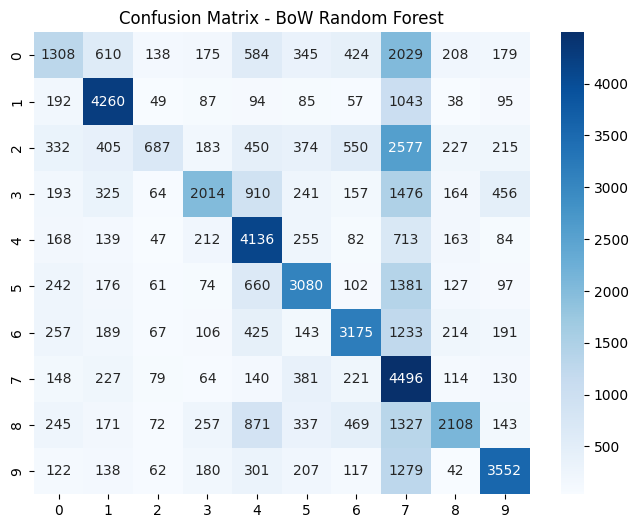

11493

In [27]:
# Cell 20: BoW + Random Forest
# This cell trains Random Forest on BoW features (fit on train, predict on test).
from sklearn.ensemble import RandomForestClassifier

n_estimators = 100
max_depth = 10  # Reduced for memory

rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
rf.fit(X_bow_train, y_train)

y_pred = rf.predict(X_bow_test)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"BoW Random Forest - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - BoW Random Forest')
plt.show()

# Save model
import joblib
joblib.dump(rf, '/content/drive/MyDrive/CSE440_Project/models/BoW_RandomForest.joblib')

# Save metrics
results = {'Representation': 'BoW', 'Model': 'Random Forest', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

gc.collect()

BoW Logistic Regression - Accuracy: 0.6122, F1 Macro: 0.6087, F1 Weighted: 0.6087
              precision    recall  f1-score   support

           0       0.51      0.41      0.46      6000
           1       0.74      0.79      0.77      6000
           2       0.45      0.42      0.43      6000
           3       0.52      0.61      0.56      6000
           4       0.66      0.70      0.68      5999
           5       0.69      0.69      0.69      6000
           6       0.70      0.64      0.67      6000
           7       0.58      0.66      0.62      6000
           8       0.54      0.46      0.50      6000
           9       0.70      0.74      0.72      6000

    accuracy                           0.61     59999
   macro avg       0.61      0.61      0.61     59999
weighted avg       0.61      0.61      0.61     59999



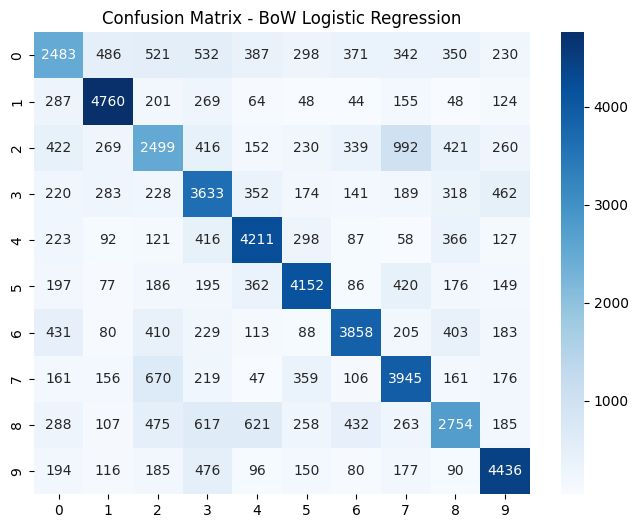

11099

In [ ]:
# Cell 21: BoW + Logistic Regression
# This cell trains Logistic Regression on BoW features.
max_iter = 1000
C = 1.0  # regularization larger C → smaller penalty, smaller C → stronger penalty.

logreg = LogisticRegression(max_iter=max_iter, C=C, random_state=42)
logreg.fit(X_bow_train, y_train)

y_pred = logreg.predict(X_bow_test)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"BoW Logistic Regression - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - BoW Logistic Regression')
plt.show()

# Save model
joblib.dump(logreg, '/content/drive/MyDrive/CSE440_Project/models/BoW_LogisticRegression.joblib')

# Save metrics
results = {'Representation': 'BoW', 'Model': 'Logistic Regression', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

gc.collect()

BoW Naive Bayes - Accuracy: 0.6020, F1 Macro: 0.6008, F1 Weighted: 0.6008
              precision    recall  f1-score   support

           0       0.48      0.46      0.47      6000
           1       0.71      0.81      0.75      6000
           2       0.48      0.40      0.43      6000
           3       0.43      0.62      0.51      6000
           4       0.63      0.70      0.66      5999
           5       0.73      0.65      0.69      6000
           6       0.74      0.59      0.66      6000
           7       0.63      0.65      0.64      6000
           8       0.59      0.44      0.50      6000
           9       0.69      0.70      0.69      6000

    accuracy                           0.60     59999
   macro avg       0.61      0.60      0.60     59999
weighted avg       0.61      0.60      0.60     59999



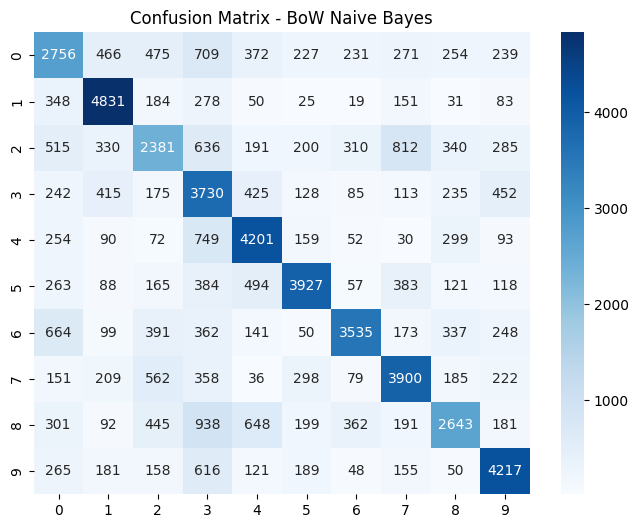

11099

In [ ]:
# Cell 22: BoW + Naive Bayes
# This cell trains Naive Bayes on BoW features.
alpha = 1.0  # 1.0 Standard Laplace smoothing (prevents zero probability)

nb = MultinomialNB(alpha=alpha)
nb.fit(X_bow_train, y_train)

y_pred = nb.predict(X_bow_test)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"BoW Naive Bayes - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - BoW Naive Bayes')
plt.show()

# Save model
joblib.dump(nb, '/content/drive/MyDrive/CSE440_Project/models/BoW_NaiveBayes.joblib')

# Save metrics
results = {'Representation': 'BoW', 'Model': 'Naive Bayes', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

gc.collect()

Epoch 1/5
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.4785 - loss: 1.5934 - val_accuracy: 0.6546 - val_loss: 1.0907 - learning_rate: 0.0010
Epoch 2/5
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 4s 725us/step - accuracy: 0.6021 - loss: 1.2712 - val_accuracy: 0.6591 - val_loss: 1.0782 - learning_rate: 0.0010
Epoch 3/5
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 2s 320us/step - accuracy: 0.4687 - loss: 1.7107 - val_accuracy: 0.6526 - val_loss: 1.0972 - learning_rate: 0.0010
Epoch 4/5
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 1s 261us/step - accuracy: 0.4375 - loss: 1.4033 - val_accuracy: 0.6513 - val_loss: 1.0972 - learning_rate: 5.0000e-04
BoW Deep Neural Network - Accuracy: 0.6231, F1 Macro: 0.6215, F1 Weighted: 0.6215
              precision    recall  f1-score   support

           0       0.59      0.40      0.48      6000
           1       0.81      0.76      0.78      6000
           2       0.42      0.51      0.46      6000
           3       0.58      0.58      0.58      6000
           4       0.63 

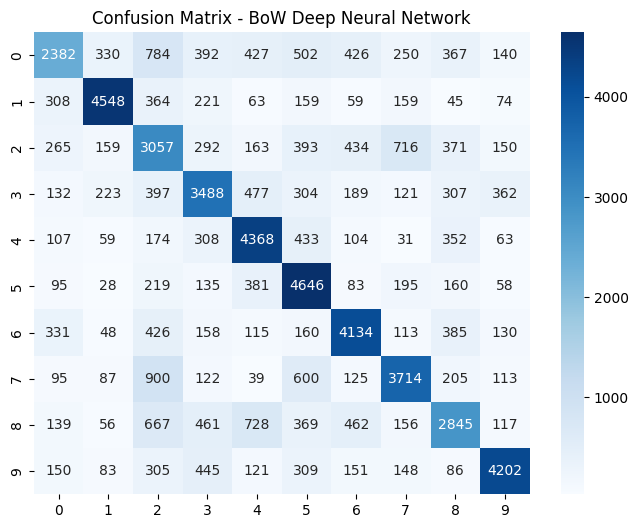

50657

In [ ]:
# Cell 23: BoW + Deep Neural Network
# This cell trains DNN on BoW features using GPU and generator for memory, fixing index mismatch and save_weights issue.
set_global_policy('mixed_float16')

hidden_units1 = 128
hidden_units2 = 64
dropout_rate = 0.3
epochs = 5
batch_size = 16
learning_rate = 0.001
validation_split = 0.1
subsample_frac = 0.7

# Ensure subsampling aligns with X_bow_train and y_train
n_samples = X_bow_train.shape[0]
subsample_idx = np.random.choice(n_samples, int(n_samples * subsample_frac), replace=False)
X_bow_train_sub = X_bow_train[subsample_idx]
y_train_sub = y_train.values[subsample_idx]  # Use .values to get numpy array and avoid index issues

def bow_generator(X_sparse, y, batch_size, shuffle=True):
    n_samples = X_sparse.shape[0]
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, n_samples, batch_size):
        batch_idx = indices[start: start + batch_size]
        yield X_sparse[batch_idx].toarray().astype(np.float32), y[batch_idx]

model = Sequential([
    Dense(hidden_units1, input_shape=(X_bow_train_sub.shape[1],), activation='relu', dtype='float32'),
    Dropout(dropout_rate),
    Dense(hidden_units2, activation='relu', dtype='float32'),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

steps_per_epoch = int((1 - validation_split) * len(y_train_sub) / batch_size)
val_steps = int(validation_split * len(y_train_sub) / batch_size)
train_gen = bow_generator(X_bow_train_sub, y_train_sub, batch_size, shuffle=True)
val_gen = bow_generator(X_bow_train_sub, y_train_sub, batch_size, shuffle=False)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, validation_data=val_gen, validation_steps=val_steps,
                        epochs=epochs, callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_bow_test.toarray().astype(np.float32), verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"BoW Deep Neural Network - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - BoW Deep Neural Network')
plt.show()

# Save model and weights with explicit .h5 extension
save_dir = '/content/drive/MyDrive/CSE440_Project/models/'
os.makedirs(save_dir, exist_ok=True)
model.save(save_dir + 'BoW_DNN.h5')
model.save_weights(save_dir + 'BoW_DNN.weights.h5')  # Explicitly using .h5 as per TensorFlow expectation

with open(save_dir + 'history_BoW_DNN.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save(save_dir + 'probs_BoW_DNN.npy', y_pred_prob)
np.save(save_dir + 'cm_BoW_DNN.npy', cm)

# Save metrics
results = {'Representation': 'BoW', 'Model': 'Deep Neural Network', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv(save_dir + 'model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, X_bow_train_sub, y_train_sub, history, train_gen, val_gen
gc.collect()

TF-IDF Random Forest - Accuracy: 0.4802, F1 Macro: 0.4682, F1 Weighted: 0.4682
              precision    recall  f1-score   support

           0       0.33      0.25      0.28      6000
           1       0.64      0.70      0.67      6000
           2       0.49      0.10      0.16      6000
           3       0.46      0.39      0.42      6000
           4       0.48      0.69      0.57      5999
           5       0.56      0.50      0.53      6000
           6       0.59      0.52      0.55      6000
           7       0.29      0.72      0.41      6000
           8       0.60      0.35      0.44      6000
           9       0.71      0.58      0.64      6000

    accuracy                           0.48     59999
   macro avg       0.51      0.48      0.47     59999
weighted avg       0.51      0.48      0.47     59999



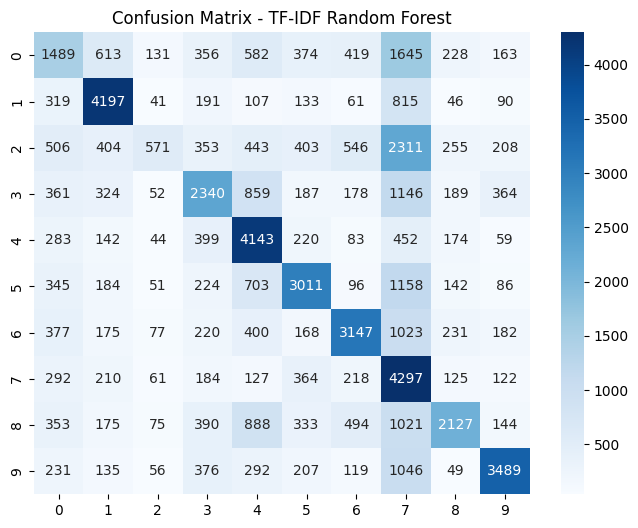

11499

In [36]:
# Cell 24: TF-IDF + Random Forest
# This cell trains Random Forest on TF-IDF features.
n_estimators = 100
max_depth = 10

rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
rf.fit(X_tfidf_train, y_train)

y_pred = rf.predict(X_tfidf_test)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"TF-IDF Random Forest - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - TF-IDF Random Forest')
plt.show()

# Save model
joblib.dump(rf, '/content/drive/MyDrive/CSE440_Project/models/TF-IDF_RandomForest.joblib')

# Save metrics
results = {'Representation': 'TF-IDF', 'Model': 'Random Forest', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

gc.collect()

TF-IDF Logistic Regression - Accuracy: 0.6374, F1 Macro: 0.6341, F1 Weighted: 0.6341
              precision    recall  f1-score   support

           0       0.53      0.45      0.48      6000
           1       0.76      0.81      0.78      6000
           2       0.49      0.44      0.47      6000
           3       0.58      0.59      0.58      6000
           4       0.66      0.73      0.70      5999
           5       0.69      0.73      0.71      6000
           6       0.70      0.69      0.69      6000
           7       0.62      0.69      0.66      6000
           8       0.55      0.51      0.53      6000
           9       0.75      0.74      0.74      6000

    accuracy                           0.64     59999
   macro avg       0.63      0.64      0.63     59999
weighted avg       0.63      0.64      0.63     59999



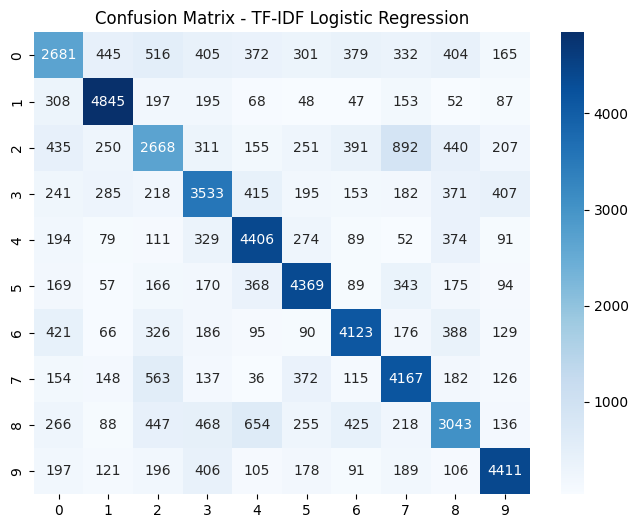

11099

In [37]:
# Cell 25: TF-IDF + Logistic Regression
# This cell trains Logistic Regression on TF-IDF features.
max_iter = 1000
C = 1.0

logreg = LogisticRegression(max_iter=max_iter, C=C, random_state=42)
logreg.fit(X_tfidf_train, y_train)

y_pred = logreg.predict(X_tfidf_test)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"TF-IDF Logistic Regression - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - TF-IDF Logistic Regression')
plt.show()

# Save model
joblib.dump(logreg, '/content/drive/MyDrive/CSE440_Project/models/TF-IDF_LogisticRegression.joblib')

# Save metrics
results = {'Representation': 'TF-IDF', 'Model': 'Logistic Regression', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

gc.collect()

TF-IDF Naive Bayes - Accuracy: 0.6212, F1 Macro: 0.6174, F1 Weighted: 0.6174
              precision    recall  f1-score   support

           0       0.52      0.45      0.48      6000
           1       0.72      0.81      0.76      6000
           2       0.51      0.40      0.45      6000
           3       0.53      0.56      0.55      6000
           4       0.58      0.76      0.66      5999
           5       0.69      0.71      0.70      6000
           6       0.70      0.66      0.68      6000
           7       0.63      0.68      0.65      6000
           8       0.54      0.50      0.52      6000
           9       0.77      0.68      0.72      6000

    accuracy                           0.62     59999
   macro avg       0.62      0.62      0.62     59999
weighted avg       0.62      0.62      0.62     59999



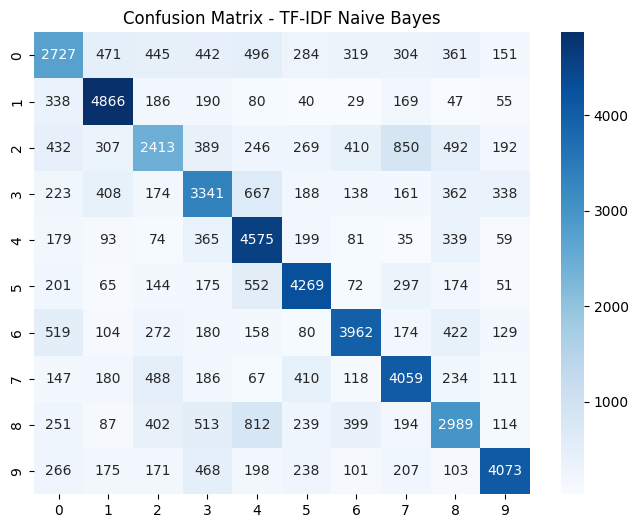

11099

In [38]:
# Cell 26: TF-IDF + Naive Bayes
# This cell trains Naive Bayes on TF-IDF features.
alpha = 1.0

nb = MultinomialNB(alpha=alpha)
nb.fit(X_tfidf_train, y_train)

y_pred = nb.predict(X_tfidf_test)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"TF-IDF Naive Bayes - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - TF-IDF Naive Bayes')
plt.show()

# Save model
joblib.dump(nb, '/content/drive/MyDrive/CSE440_Project/models/TF-IDF_NaiveBayes.joblib')

# Save metrics
results = {'Representation': 'TF-IDF', 'Model': 'Naive Bayes', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

gc.collect()

Epoch 1/5
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.5128 - loss: 1.4889 - val_accuracy: 0.6704 - val_loss: 1.0311 - learning_rate: 0.0010
Epoch 2/5
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 3s 572us/step - accuracy: 0.6143 - loss: 1.2248 - val_accuracy: 0.6702 - val_loss: 1.0170 - learning_rate: 0.0010
Epoch 3/5
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 1s 262us/step - accuracy: 0.6875 - loss: 1.1639 - val_accuracy: 0.6687 - val_loss: 1.0369 - learning_rate: 0.0010
Epoch 4/5
5512/5512 ━━━━━━━━━━━━━━━━━━━━ 2s 269us/step - accuracy: 0.6875 - loss: 1.0922 - val_accuracy: 0.6801 - val_loss: 1.0224 - learning_rate: 5.0000e-04
TF-IDF Deep Neural Network - Accuracy: 0.6351, F1 Macro: 0.6305, F1 Weighted: 0.6305
              precision    recall  f1-score   support

           0       0.55      0.45      0.49      6000
           1       0.78      0.78      0.78      6000
           2       0.53      0.40      0.45      6000
           3       0.60      0.55      0.58      6000
           4       0.

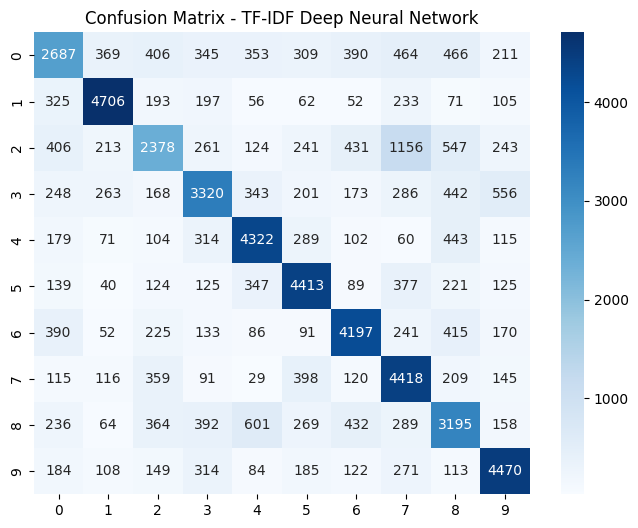

54150

In [42]:
# Cell 27: TF-IDF + Deep Neural Network
# This cell trains DNN on TF-IDF features using GPU and generator for memory, updated for .keras format.
set_global_policy('mixed_float16')

hidden_units1 = 128
hidden_units2 = 64
dropout_rate = 0.3
epochs = 5
batch_size = 16
learning_rate = 0.001
validation_split = 0.1
subsample_frac = 0.7

# Ensure subsampling aligns with X_tfidf_train and y_train
n_samples = X_tfidf_train.shape[0]
subsample_idx = np.random.choice(n_samples, int(n_samples * subsample_frac), replace=False)
X_tfidf_train_sub = X_tfidf_train[subsample_idx]
y_train_sub = y_train.values[subsample_idx]  # Use .values to get numpy array and avoid index issues

def tfidf_generator(X_sparse, y, batch_size, shuffle=True):
    n_samples = X_sparse.shape[0]
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, n_samples, batch_size):
        batch_idx = indices[start:start + batch_size]
        yield X_sparse[batch_idx].toarray().astype(np.float32), y[batch_idx]

model = Sequential([
    Dense(hidden_units1, input_shape=(X_tfidf_train_sub.shape[1],), activation='relu', dtype='float32'),
    Dropout(dropout_rate),
    Dense(hidden_units2, activation='relu', dtype='float32'),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

steps_per_epoch = int((1 - validation_split) * len(y_train_sub) / batch_size)
val_steps = int(validation_split * len(y_train_sub) / batch_size)
train_gen = tfidf_generator(X_tfidf_train_sub, y_train_sub, batch_size, shuffle=True)
val_gen = tfidf_generator(X_tfidf_train_sub, y_train_sub, batch_size, shuffle=False)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, validation_data=val_gen, validation_steps=val_steps,
                        epochs=epochs, callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_tfidf_test.toarray().astype(np.float32), verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"TF-IDF Deep Neural Network - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - TF-IDF Deep Neural Network')
plt.show()

# Save model and weights in .keras format
save_dir = '/content/drive/MyDrive/CSE440_Project/models/'
os.makedirs(save_dir, exist_ok=True)
model.save(save_dir + 'TF-IDF_DNN.keras')  # Updated to .keras format
model.save_weights(save_dir + 'TF-IDF_DNN.weights.h5')  # Updated to .keras format

with open(save_dir + 'history_TF-IDF_DNN.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save(save_dir + 'probs_TF-IDF_DNN.npy', y_pred_prob)
np.save(save_dir + 'cm_TF-IDF_DNN.npy', cm)

# Save metrics
results = {'Representation': 'TF-IDF', 'Model': 'Deep Neural Network', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv(save_dir + 'model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, X_tfidf_train_sub, y_train_sub, history, train_gen, val_gen
gc.collect()

Epoch 1/5
5513/5513 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.5207 - loss: 1.4535 - val_accuracy: 0.6460 - val_loss: 1.0937 - learning_rate: 0.0010
Epoch 2/5
5513/5513 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.6282 - loss: 1.1717 - val_accuracy: 0.6485 - val_loss: 1.0751 - learning_rate: 0.0010
Epoch 3/5
5513/5513 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6386 - loss: 1.1358 - val_accuracy: 0.6541 - val_loss: 1.0587 - learning_rate: 0.0010
Epoch 4/5
5513/5513 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6417 - loss: 1.1280 - val_accuracy: 0.6513 - val_loss: 1.0580 - learning_rate: 0.0010
Epoch 5/5
5513/5513 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.6456 - loss: 1.1129 - val_accuracy: 0.6618 - val_loss: 1.0456 - learning_rate: 0.0010
GloVe Deep Neural Network - Accuracy: 0.6619, F1 Macro: 0.6519, F1 Weighted: 0.6519
              precision    recall  f1-score   support

           0       0.65      0.40      0.49      6000
           1       0.77      0.85    

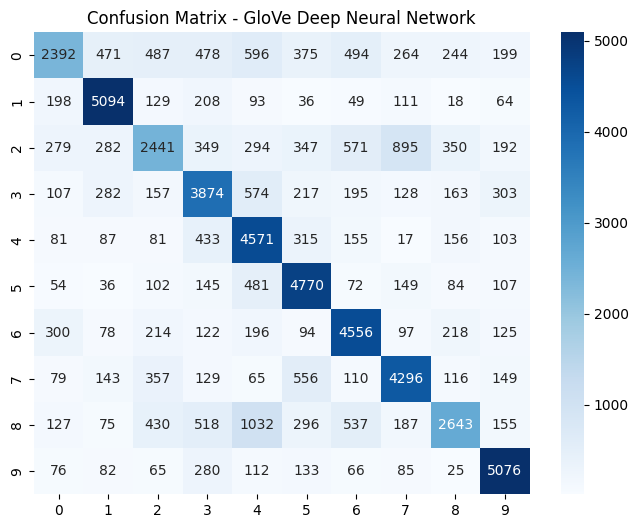

16533

In [ ]:
# Cell 28: GloVe + Deep Neural Network
# This cell trains DNN on GloVe average embeddings.
set_global_policy('mixed_float16')

hidden_units1 = 128
hidden_units2 = 64
dropout_rate = 0.3
epochs = 5
batch_size = 16
learning_rate = 0.001
validation_split = 0.1
subsample_frac = 0.7

X_glove_avg_train = np.load('/content/X_glove_avg_train.npy')
X_glove_avg_test = np.load('/content/X_glove_avg_test.npy')

subsample_idx = np.random.choice(len(y_train), int(len(y_train) * subsample_frac), replace=False)
X_glove_avg_train_sub = X_glove_avg_train[subsample_idx]
y_train_sub = y_train.iloc[subsample_idx]

model = Sequential([
    Dense(hidden_units1, input_shape=(embedding_dim,), activation='relu', dtype='float32'),
    Dropout(dropout_rate),
    Dense(hidden_units2, activation='relu', dtype='float32'),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(X_glove_avg_train_sub, y_train_sub, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_glove_avg_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"GloVe Deep Neural Network - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GloVe Deep Neural Network')
plt.show()

# Save model
model.save('/content/drive/MyDrive/CSE440_Project/models/GloVe_DNN.keras')
model.save_weights('/content/drive/MyDrive/CSE440_Project/models/GloVe_DNN.weights.h5')

with open('/content/drive/MyDrive/CSE440_Project/models/history_GloVe_DNN.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('/content/drive/MyDrive/CSE440_Project/models/probs_GloVe_DNN.npy', y_pred_prob)
np.save('/content/drive/MyDrive/CSE440_Project/models/cm_GloVe_DNN.npy', cm)

# Save metrics
results = {'Representation': 'GloVe', 'Model': 'Deep Neural Network', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, X_glove_avg_train_sub, y_train_sub, history
gc.collect()

Epoch 1/5
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 71s 9ms/step - accuracy: 0.2104 - loss: 2.1879 - val_accuracy: 0.2302 - val_loss: 2.1334 - learning_rate: 0.0010
Epoch 2/5
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step - accuracy: 0.2552 - loss: 2.1005 - val_accuracy: 0.2616 - val_loss: 2.1088 - learning_rate: 0.0010
Epoch 3/5
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 84s 9ms/step - accuracy: 0.2169 - loss: 2.1762 - val_accuracy: 0.2289 - val_loss: 2.1591 - learning_rate: 0.0010
Epoch 4/5
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.2562 - loss: 2.1027 - val_accuracy: 0.2744 - val_loss: 2.0749 - learning_rate: 5.0000e-04
Epoch 5/5
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.2761 - loss: 2.0552 - val_accuracy: 0.2520 - val_loss: 2.1021 - learning_rate: 5.0000e-04
GloVe SimpleRNN - Accuracy: 0.2746, F1 Macro: 0.2476, F1 Weighted: 0.2476
              precision    recall  f1-score   support

           0       0.25      0.02      0.04      6000
           1       0.61      0.57      

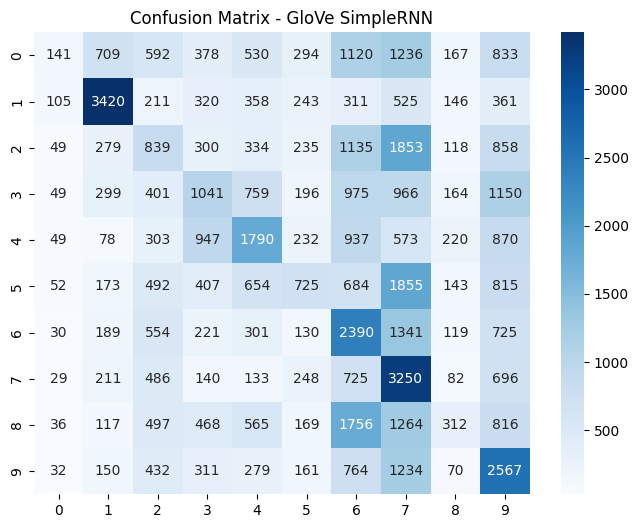

17315

In [44]:
# Cell 29: GloVe + SimpleRNN
# This cell trains SimpleRNN on padded sequences with GloVe embeddings.
set_global_policy('mixed_float16')

rnn_units = 64  # Reduced
trainable_embedding = False
epochs = 5
batch_size = 16
learning_rate = 0.001
validation_split = 0.1

model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_glove], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding),
    SimpleRNN(rnn_units, dtype='float32'),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"GloVe SimpleRNN - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GloVe SimpleRNN')
plt.show()

# Save model
model.save('/content/drive/MyDrive/CSE440_Project/models/GloVe_SimpleRNN.keras')
model.save_weights('/content/drive/MyDrive/CSE440_Project/models/GloVe_SimpleRNN.weights.h5')

with open('/content/drive/MyDrive/CSE440_Project/models/history_GloVe_SimpleRNN.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('/content/drive/MyDrive/CSE440_Project/models/probs_GloVe_SimpleRNN.npy', y_pred_prob)
np.save('/content/drive/MyDrive/CSE440_Project/models/cm_GloVe_SimpleRNN.npy', cm)

# Save metrics
results = {'Representation': 'GloVe', 'Model': 'SimpleRNN', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, history
gc.collect()

Epoch 1/5
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 70s 8ms/step - accuracy: 0.4946 - loss: 1.4933 - val_accuracy: 0.6124 - val_loss: 1.1870 - learning_rate: 0.0010
Epoch 2/5
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 60s 8ms/step - accuracy: 0.6268 - loss: 1.1430 - val_accuracy: 0.6257 - val_loss: 1.1541 - learning_rate: 0.0010
Epoch 3/5
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.6468 - loss: 1.0877 - val_accuracy: 0.6299 - val_loss: 1.1366 - learning_rate: 0.0010
Epoch 4/5
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.6575 - loss: 1.0561 - val_accuracy: 0.6328 - val_loss: 1.1181 - learning_rate: 0.0010
Epoch 5/5
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.6619 - loss: 1.0326 - val_accuracy: 0.6376 - val_loss: 1.1137 - learning_rate: 0.0010
GloVe GRU - Accuracy: 0.6421, F1 Macro: 0.6366, F1 Weighted: 0.6366
              precision    recall  f1-score   support

           0       0.55      0.43      0.48      6000
           1       0.71      0.85      0.77      6000

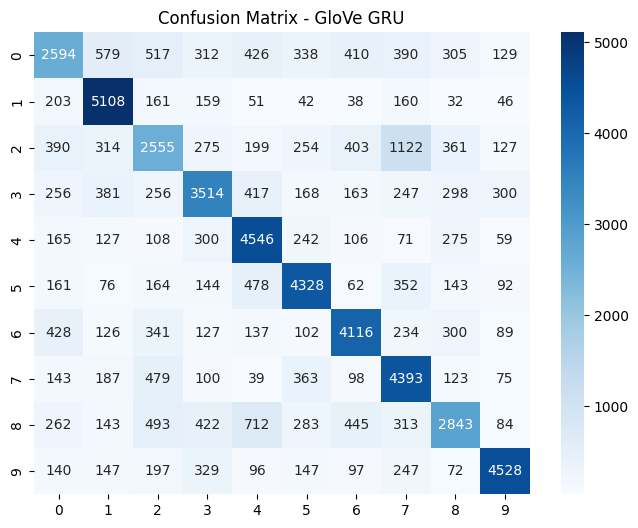

19099

In [45]:
# Cell 30: GloVe + GRU
# This cell trains GRU on padded sequences with GloVe embeddings.
set_global_policy('mixed_float16')

gru_units = 64  # Reduced
trainable_embedding = False
epochs = 5
batch_size = 16
learning_rate = 0.001
validation_split = 0.1

model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_glove], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding),
    GRU(gru_units, dtype='float32'),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"GloVe GRU - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GloVe GRU')
plt.show()

# Save model
model.save('/content/drive/MyDrive/CSE440_Project/models/GloVe_GRU.keras')
model.save_weights('/content/drive/MyDrive/CSE440_Project/models/GloVe_GRU.weights.h5')

with open('/content/drive/MyDrive/CSE440_Project/models/history_GloVe_GRU.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('/content/drive/MyDrive/CSE440_Project/models/probs_GloVe_GRU.npy', y_pred_prob)
np.save('/content/drive/MyDrive/CSE440_Project/models/cm_GloVe_GRU.npy', cm)

# Save metrics
results = {'Representation': 'GloVe', 'Model': 'GRU', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, history
gc.collect()

Epoch 1/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 97s 12ms/step - accuracy: 0.4883 - loss: 1.5192 - val_accuracy: 0.5956 - val_loss: 1.2407 - learning_rate: 0.0010
Epoch 2/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 114s 8ms/step - accuracy: 0.6172 - loss: 1.1761 - val_accuracy: 0.6159 - val_loss: 1.1670 - learning_rate: 0.0010
Epoch 3/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.6391 - loss: 1.1060 - val_accuracy: 0.6225 - val_loss: 1.1507 - learning_rate: 0.0010
GloVe LSTM - Accuracy: 0.6300, F1 Macro: 0.6271, F1 Weighted: 0.6271
              precision    recall  f1-score   support

           0       0.56      0.41      0.47      6000
           1       0.78      0.79      0.78      6000
           2       0.45      0.46      0.46      6000
           3       0.64      0.53      0.58      6000
           4       0.59      0.79      0.68      5999
           5       0.69      0.70      0.70      6000
           6       0.67      0.67      0.67      6000
           7       0.65      0.65 

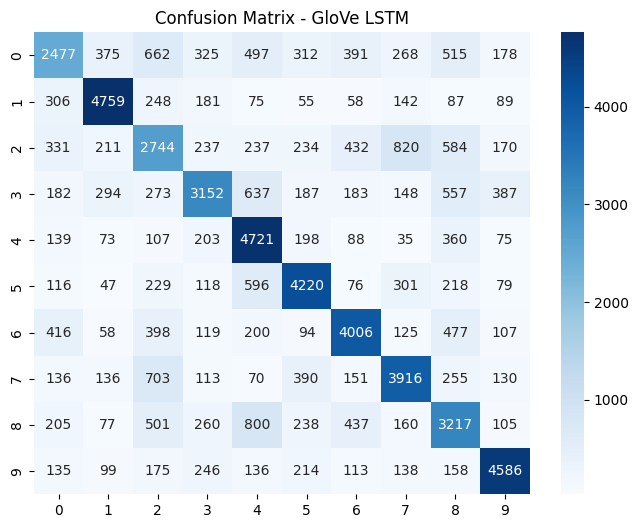

23467

In [47]:
# Cell 31: GloVe + LSTM
# This cell trains LSTM on padded sequences with GloVe embeddings.
set_global_policy('mixed_float16')

lstm_units = 64  # Reduced
trainable_embedding = False
epochs = 3
batch_size = 16
learning_rate = 0.001
validation_split = 0.1

model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_glove], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding),
    LSTM(lstm_units, dtype='float32'),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"GloVe LSTM - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GloVe LSTM')
plt.show()

# Save model
model.save('/content/drive/MyDrive/CSE440_Project/models/GloVe_LSTM.keras')
model.save_weights('/content/drive/MyDrive/CSE440_Project/models/GloVe_LSTM.weights.h5')

with open('/content/drive/MyDrive/CSE440_Project/models/history_GloVe_LSTM.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('/content/drive/MyDrive/CSE440_Project/models/probs_GloVe_LSTM.npy', y_pred_prob)
np.save('/content/drive/MyDrive/CSE440_Project/models/cm_GloVe_LSTM.npy', cm)

# Save metrics
results = {'Representation': 'GloVe', 'Model': 'LSTM', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, history
gc.collect()

Epoch 1/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 117s 14ms/step - accuracy: 0.2412 - loss: 2.1304 - val_accuracy: 0.1931 - val_loss: 2.2416 - learning_rate: 0.0010
Epoch 2/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 139s 14ms/step - accuracy: 0.2399 - loss: 2.1291 - val_accuracy: 0.2874 - val_loss: 2.0346 - learning_rate: 0.0010
Epoch 3/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 141s 14ms/step - accuracy: 0.2755 - loss: 2.0524 - val_accuracy: 0.2656 - val_loss: 2.0654 - learning_rate: 0.0010
GloVe Bidirectional SimpleRNN - Accuracy: 0.2869, F1 Macro: 0.2582, F1 Weighted: 0.2582
              precision    recall  f1-score   support

           0       0.17      0.15      0.16      6000
           1       0.33      0.57      0.42      6000
           2       0.18      0.09      0.12      6000
           3       0.34      0.05      0.09      6000
           4       0.28      0.49      0.35      5999
           5       0.31      0.29      0.30      6000
           6       0.41      0.14      0.21      6000
           

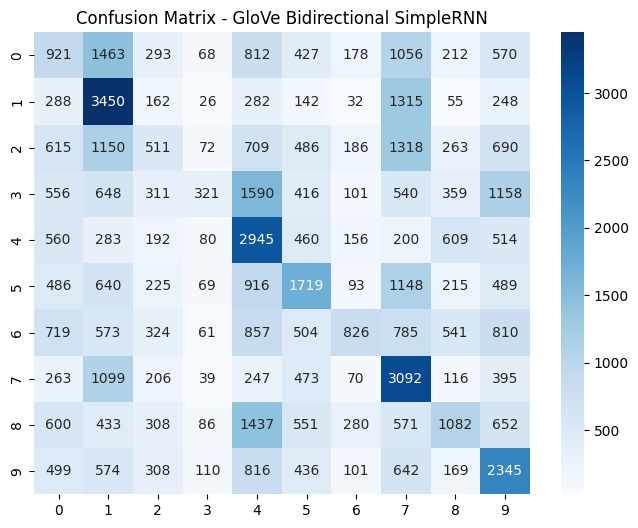

18011

In [48]:
# Cell 32: GloVe + Bidirectional SimpleRNN
# This cell trains Bidirectional SimpleRNN on padded sequences with GloVe embeddings.
set_global_policy('mixed_float16')

rnn_units = 64
trainable_embedding = False
epochs = 3
batch_size = 16
learning_rate = 0.001
validation_split = 0.1

model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_glove], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding),
    Bidirectional(SimpleRNN(rnn_units, dtype='float32')),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"GloVe Bidirectional SimpleRNN - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GloVe Bidirectional SimpleRNN')
plt.show()

# Save model
model.save('/content/drive/MyDrive/CSE440_Project/models/GloVe_BiSimpleRNN.keras')
model.save_weights('/content/drive/MyDrive/CSE440_Project/models/GloVe_BiSimpleRNN.weights.h5')

with open('/content/drive/MyDrive/CSE440_Project/models/history_GloVe_BiSimpleRNN.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('/content/drive/MyDrive/CSE440_Project/models/probs_GloVe_BiSimpleRNN.npy', y_pred_prob)
np.save('/content/drive/MyDrive/CSE440_Project/models/cm_GloVe_BiSimpleRNN.npy', cm)

# Save metrics
results = {'Representation': 'GloVe', 'Model': 'Bidirectional SimpleRNN', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, history
gc.collect()

Epoch 1/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 97s 12ms/step - accuracy: 0.4985 - loss: 1.4883 - val_accuracy: 0.6017 - val_loss: 1.2085 - learning_rate: 0.0010
Epoch 2/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 140s 12ms/step - accuracy: 0.6294 - loss: 1.1401 - val_accuracy: 0.6216 - val_loss: 1.1458 - learning_rate: 0.0010
Epoch 3/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 140s 12ms/step - accuracy: 0.6476 - loss: 1.0823 - val_accuracy: 0.6292 - val_loss: 1.1295 - learning_rate: 0.0010
GloVe Bidirectional GRU - Accuracy: 0.6341, F1 Macro: 0.6310, F1 Weighted: 0.6310
              precision    recall  f1-score   support

           0       0.56      0.42      0.48      6000
           1       0.74      0.82      0.78      6000
           2       0.44      0.47      0.46      6000
           3       0.61      0.57      0.59      6000
           4       0.63      0.76      0.69      5999
           5       0.75      0.66      0.70      6000
           6       0.69      0.67      0.68      6000
           7      

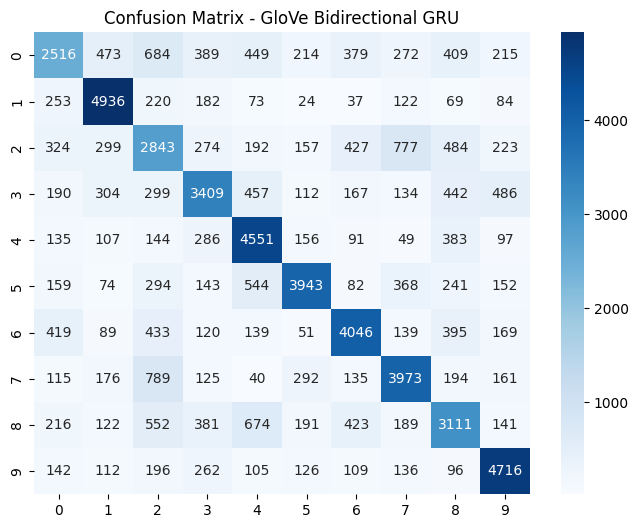

22523

In [49]:
# Cell 33: GloVe + Bidirectional GRU
# This cell trains Bidirectional GRU on padded sequences with GloVe embeddings.
set_global_policy('mixed_float16')

gru_units = 64
trainable_embedding = False
epochs = 3
batch_size = 16
learning_rate = 0.001
validation_split = 0.1

model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_glove], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding),
    Bidirectional(GRU(gru_units, dtype='float32')),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"GloVe Bidirectional GRU - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GloVe Bidirectional GRU')
plt.show()

# Save model
model.save('/content/drive/MyDrive/CSE440_Project/models/GloVe_BiGRU.keras')
model.save_weights('/content/drive/MyDrive/CSE440_Project/models/GloVe_BiGRU.weights.h5')

with open('/content/drive/MyDrive/CSE440_Project/models/history_GloVe_BiGRU.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('/content/drive/MyDrive/CSE440_Project/models/probs_GloVe_BiGRU.npy', y_pred_prob)
np.save('/content/drive/MyDrive/CSE440_Project/models/cm_GloVe_BiGRU.npy', cm)

# Save metrics
results = {'Representation': 'GloVe', 'Model': 'Bidirectional GRU', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, history
gc.collect()

Epoch 1/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 99s 12ms/step - accuracy: 0.4893 - loss: 1.5203 - val_accuracy: 0.6001 - val_loss: 1.2305 - learning_rate: 0.0010
Epoch 2/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 138s 12ms/step - accuracy: 0.6182 - loss: 1.1730 - val_accuracy: 0.6141 - val_loss: 1.1883 - learning_rate: 0.0010
Epoch 3/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 93s 12ms/step - accuracy: 0.6400 - loss: 1.1060 - val_accuracy: 0.6286 - val_loss: 1.1434 - learning_rate: 0.0010
GloVe Bidirectional LSTM - Accuracy: 0.6333, F1 Macro: 0.6301, F1 Weighted: 0.6301
              precision    recall  f1-score   support

           0       0.49      0.46      0.48      6000
           1       0.77      0.80      0.79      6000
           2       0.48      0.43      0.45      6000
           3       0.60      0.60      0.60      6000
           4       0.66      0.73      0.70      5999
           5       0.62      0.76      0.68      6000
           6       0.69      0.65      0.67      6000
           7      

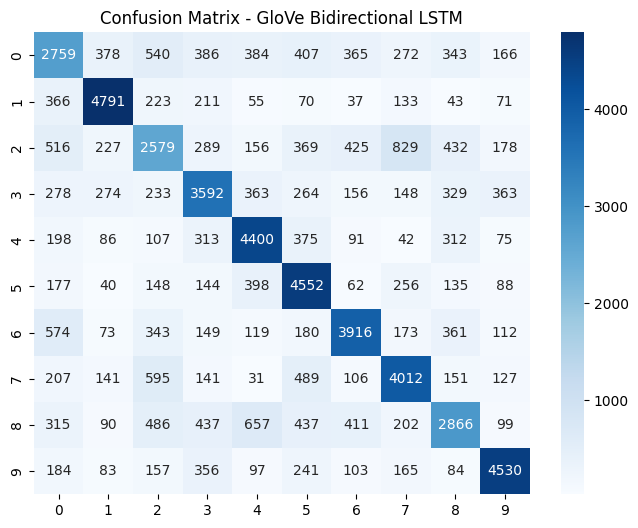

19674

In [50]:
# Cell 34: GloVe + Bidirectional LSTM
# This cell trains Bidirectional LSTM on padded sequences with GloVe embeddings.
set_global_policy('mixed_float16')

lstm_units = 64
trainable_embedding = False
epochs = 3
batch_size = 16
learning_rate = 0.001
validation_split = 0.1

model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_glove], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding),
    Bidirectional(LSTM(lstm_units, dtype='float32')),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"GloVe Bidirectional LSTM - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GloVe Bidirectional LSTM')
plt.show()

# Save model
model.save('/content/drive/MyDrive/CSE440_Project/models/GloVe_BiLSTM.keras')
model.save_weights('/content/drive/MyDrive/CSE440_Project/models/GloVe_BiLSTM.weights.h5')

with open('/content/drive/MyDrive/CSE440_Project/models/history_GloVe_BiLSTM.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('/content/drive/MyDrive/CSE440_Project/models/probs_GloVe_BiLSTM.npy', y_pred_prob)
np.save('/content/drive/MyDrive/CSE440_Project/models/cm_GloVe_BiLSTM.npy', cm)

# Save metrics
results = {'Representation': 'GloVe', 'Model': 'Bidirectional LSTM', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, history
gc.collect()

Epoch 1/3
5513/5513 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.5541 - loss: 1.3690 - val_accuracy: 0.6643 - val_loss: 1.0553 - learning_rate: 0.0010
Epoch 2/3
5513/5513 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.6543 - loss: 1.1025 - val_accuracy: 0.6667 - val_loss: 1.0338 - learning_rate: 0.0010
Epoch 3/3
5513/5513 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.6601 - loss: 1.0837 - val_accuracy: 0.6717 - val_loss: 1.0183 - learning_rate: 0.0010
Skip-gram Deep Neural Network - Accuracy: 0.6785, F1 Macro: 0.6724, F1 Weighted: 0.6724
              precision    recall  f1-score   support

           0       0.59      0.48      0.53      6000
           1       0.79      0.86      0.82      6000
           2       0.56      0.41      0.47      6000
           3       0.62      0.67      0.64      6000
           4       0.70      0.73      0.71      5999
           5       0.71      0.81      0.76      6000
           6       0.65      0.79      0.72      6000
           7     

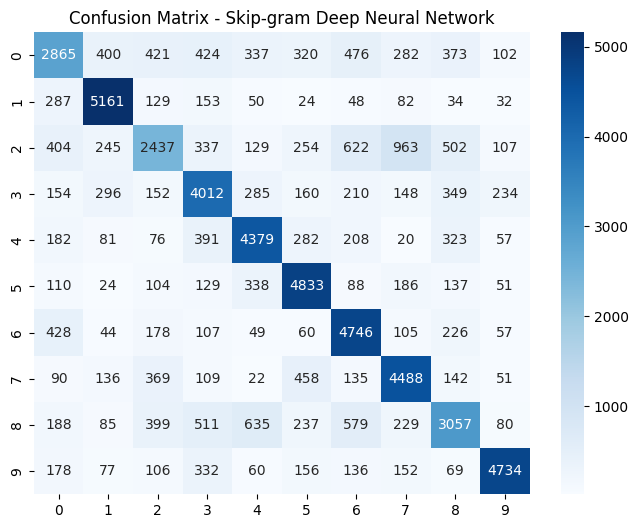

19750

In [51]:
# Cell 35: Skip-gram + Deep Neural Network
# This cell trains DNN on Skip-gram average embeddings.
set_global_policy('mixed_float16')

hidden_units1 = 128
hidden_units2 = 64
dropout_rate = 0.3
epochs = 3
batch_size = 16
learning_rate = 0.001
validation_split = 0.1
subsample_frac = 0.7

X_sg_avg_train = np.load('/content/X_sg_avg_train.npy')
X_sg_avg_test = np.load('/content/X_sg_avg_test.npy')

subsample_idx = np.random.choice(len(y_train), int(len(y_train) * subsample_frac), replace=False)
X_sg_avg_train_sub = X_sg_avg_train[subsample_idx]
y_train_sub = y_train.iloc[subsample_idx]

model = Sequential([
    Dense(hidden_units1, input_shape=(embedding_dim,), activation='relu', dtype='float32'),
    Dropout(dropout_rate),
    Dense(hidden_units2, activation='relu', dtype='float32'),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(X_sg_avg_train_sub, y_train_sub, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_sg_avg_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Skip-gram Deep Neural Network - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Skip-gram Deep Neural Network')
plt.show()

# Save model
model.save('/content/drive/MyDrive/CSE440_Project/models/Skipgram_DNN.keras')
model.save_weights('/content/drive/MyDrive/CSE440_Project/models/Skipgram_DNN.weights.h5')

with open('/content/drive/MyDrive/CSE440_Project/models/history_Skipgram_DNN.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('/content/drive/MyDrive/CSE440_Project/models/probs_Skipgram_DNN.npy', y_pred_prob)
np.save('/content/drive/MyDrive/CSE440_Project/models/cm_Skipgram_DNN.npy', cm)

# Save metrics
results = {'Representation': 'Skip-gram', 'Model': 'Deep Neural Network', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, X_sg_avg_train_sub, y_train_sub, history
gc.collect()

Epoch 1/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 71s 9ms/step - accuracy: 0.2229 - loss: 2.1502 - val_accuracy: 0.2496 - val_loss: 2.1073 - learning_rate: 0.0010
Epoch 2/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.2233 - loss: 2.1673 - val_accuracy: 0.2338 - val_loss: 2.1480 - learning_rate: 0.0010
Epoch 3/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.2402 - loss: 2.1324 - val_accuracy: 0.2106 - val_loss: 2.1712 - learning_rate: 5.0000e-04
Skip-gram SimpleRNN - Accuracy: 0.2499, F1 Macro: 0.2267, F1 Weighted: 0.2267
              precision    recall  f1-score   support

           0       0.27      0.02      0.03      6000
           1       0.59      0.64      0.61      6000
           2       0.30      0.01      0.03      6000
           3       0.23      0.13      0.17      6000
           4       0.23      0.36      0.28      5999
           5       0.18      0.28      0.22      6000
           6       0.21      0.38      0.27      6000
           7       0.30

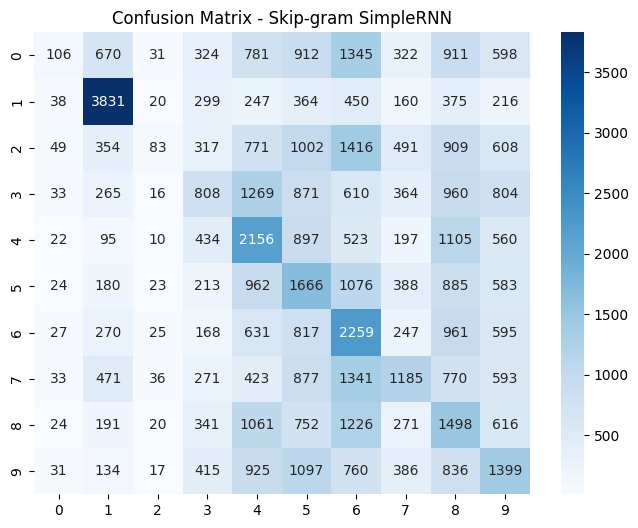

17095

In [52]:
# Cell 36: Skip-gram + SimpleRNN
# This cell trains SimpleRNN on padded sequences with Skip-gram embeddings.
set_global_policy('mixed_float16')

rnn_units = 64
trainable_embedding = False
epochs = 3
batch_size = 16
learning_rate = 0.001
validation_split = 0.1

embedding_matrix_sg = np.load('/content/embedding_matrix_sg.npy')

model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_sg], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding),
    SimpleRNN(rnn_units, dtype='float32'),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Skip-gram SimpleRNN - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Skip-gram SimpleRNN')
plt.show()

# Save model
model.save('/content/drive/MyDrive/CSE440_Project/models/Skipgram_SimpleRNN.keras')
model.save_weights('/content/drive/MyDrive/CSE440_Project/models/Skipgram_SimpleRNN.weights.h5')

with open('/content/drive/MyDrive/CSE440_Project/models/history_Skipgram_SimpleRNN.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('/content/drive/MyDrive/CSE440_Project/models/probs_Skipgram_SimpleRNN.npy', y_pred_prob)
np.save('/content/drive/MyDrive/CSE440_Project/models/cm_Skipgram_SimpleRNN.npy', cm)

# Save metrics
results = {'Representation': 'Skip-gram', 'Model': 'SimpleRNN', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, history
gc.collect()

Epoch 1/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 65s 8ms/step - accuracy: 0.4794 - loss: 1.5522 - val_accuracy: 0.5933 - val_loss: 1.2441 - learning_rate: 0.0010
Epoch 2/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.6081 - loss: 1.2023 - val_accuracy: 0.6102 - val_loss: 1.1955 - learning_rate: 0.0010
Epoch 3/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 62s 8ms/step - accuracy: 0.6219 - loss: 1.1598 - val_accuracy: 0.6094 - val_loss: 1.1980 - learning_rate: 0.0010
Skip-gram GRU - Accuracy: 0.6163, F1 Macro: 0.6110, F1 Weighted: 0.6110
              precision    recall  f1-score   support

           0       0.52      0.43      0.47      6000
           1       0.72      0.82      0.76      6000
           2       0.51      0.38      0.43      6000
           3       0.61      0.54      0.57      6000
           4       0.64      0.70      0.67      5999
           5       0.66      0.71      0.68      6000
           6       0.67      0.65      0.66      6000
           7       0.57      0.69

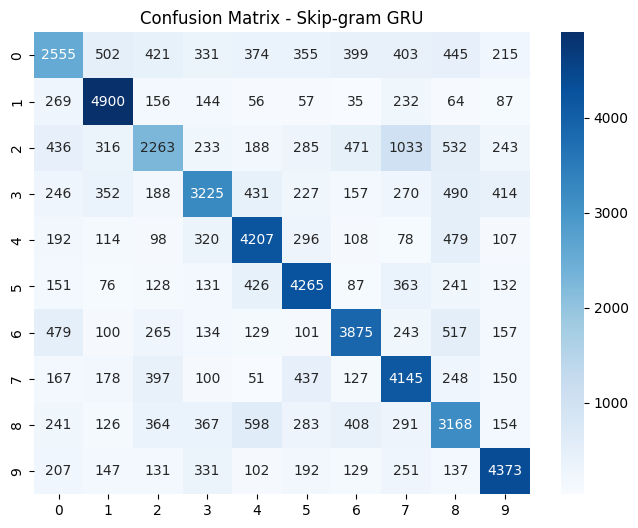

19315

In [53]:
# Cell 37: Skip-gram + GRU
# This cell trains GRU on padded sequences with Skip-gram embeddings.
set_global_policy('mixed_float16')

gru_units = 64
trainable_embedding = False
epochs = 3
batch_size = 16
learning_rate = 0.001
validation_split = 0.1

model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_sg], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding),
    GRU(gru_units, dtype='float32'),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Skip-gram GRU - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Skip-gram GRU')
plt.show()

# Save model
model.save('/content/drive/MyDrive/CSE440_Project/models/Skipgram_GRU.keras')
model.save_weights('/content/drive/MyDrive/CSE440_Project/models/Skipgram_GRU.weights.h5')

with open('/content/drive/MyDrive/CSE440_Project/models/history_Skipgram_GRU.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('/content/drive/MyDrive/CSE440_Project/models/probs_Skipgram_GRU.npy', y_pred_prob)
np.save('/content/drive/MyDrive/CSE440_Project/models/cm_Skipgram_GRU.npy', cm)

# Save metrics
results = {'Representation': 'Skip-gram', 'Model': 'GRU', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, history
gc.collect()

Epoch 1/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step - accuracy: 0.4718 - loss: 1.5902 - val_accuracy: 0.5830 - val_loss: 1.2839 - learning_rate: 0.0010
Epoch 2/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.5965 - loss: 1.2527 - val_accuracy: 0.5960 - val_loss: 1.2435 - learning_rate: 0.0010
Epoch 3/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.6135 - loss: 1.1873 - val_accuracy: 0.6081 - val_loss: 1.2075 - learning_rate: 0.0010
Skip-gram LSTM - Accuracy: 0.6119, F1 Macro: 0.6075, F1 Weighted: 0.6075
              precision    recall  f1-score   support

           0       0.57      0.41      0.47      6000
           1       0.73      0.81      0.77      6000
           2       0.50      0.39      0.43      6000
           3       0.52      0.57      0.54      6000
           4       0.57      0.75      0.65      5999
           5       0.63      0.72      0.68      6000
           6       0.66      0.66      0.66      6000
           7       0.61      0.6

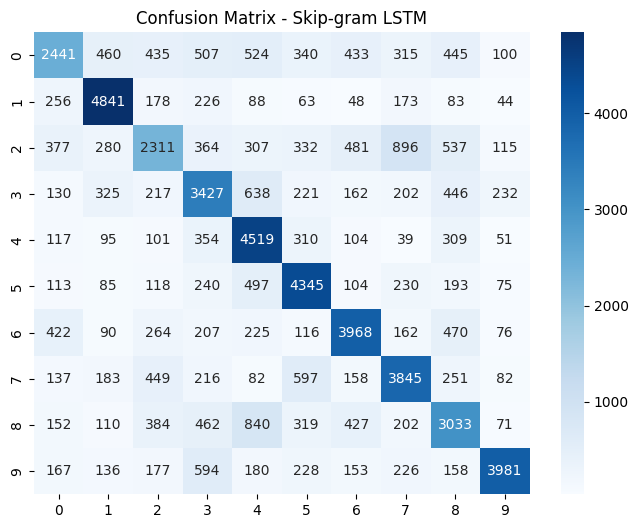

17997

In [54]:
# Cell 38: Skip-gram + LSTM
# This cell trains LSTM on padded sequences with Skip-gram embeddings.
set_global_policy('mixed_float16')

lstm_units = 64
trainable_embedding = False
epochs = 3
batch_size = 16
learning_rate = 0.001
validation_split = 0.1

model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_sg], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding),
    LSTM(lstm_units, dtype='float32'),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Skip-gram LSTM - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Skip-gram LSTM')
plt.show()

# Save model
model.save('/content/drive/MyDrive/CSE440_Project/models/Skipgram_LSTM.keras')
model.save_weights('/content/drive/MyDrive/CSE440_Project/models/Skipgram_LSTM.weights.h5')

with open('/content/drive/MyDrive/CSE440_Project/models/history_Skipgram_LSTM.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('/content/drive/MyDrive/CSE440_Project/models/probs_Skipgram_LSTM.npy', y_pred_prob)
np.save('/content/drive/MyDrive/CSE440_Project/models/cm_Skipgram_LSTM.npy', cm)

# Save metrics
results = {'Representation': 'Skip-gram', 'Model': 'LSTM', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, history
gc.collect()

Epoch 1/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 117s 14ms/step - accuracy: 0.2217 - loss: 2.1642 - val_accuracy: 0.2591 - val_loss: 2.0789 - learning_rate: 0.0010
Epoch 2/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 110s 14ms/step - accuracy: 0.2608 - loss: 2.0748 - val_accuracy: 0.2418 - val_loss: 2.1371 - learning_rate: 0.0010
Epoch 3/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 144s 14ms/step - accuracy: 0.2565 - loss: 2.0909 - val_accuracy: 0.2555 - val_loss: 2.0799 - learning_rate: 5.0000e-04
Skip-gram Bidirectional SimpleRNN - Accuracy: 0.2589, F1 Macro: 0.2265, F1 Weighted: 0.2265
              precision    recall  f1-score   support

           0       0.25      0.02      0.03      6000
           1       0.33      0.59      0.43      6000
           2       0.32      0.02      0.03      6000
           3       0.18      0.45      0.26      6000
           4       0.22      0.44      0.29      5999
           5       0.28      0.19      0.23      6000
           6       0.32      0.16      0.21      6000
   

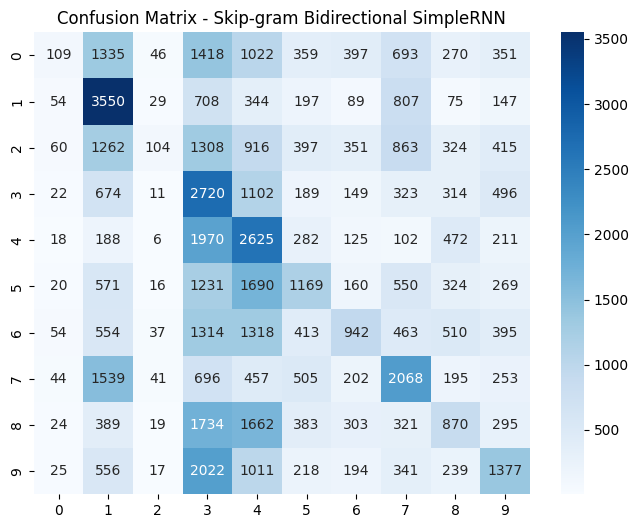

18247

In [55]:
# Cell 39: Skip-gram + Bidirectional SimpleRNN
# This cell trains Bidirectional SimpleRNN on padded sequences with Skip-gram embeddings.
set_global_policy('mixed_float16')

rnn_units = 64
trainable_embedding = False
epochs = 3
batch_size = 16
learning_rate = 0.001
validation_split = 0.1

model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_sg], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding),
    Bidirectional(SimpleRNN(rnn_units, dtype='float32')),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Skip-gram Bidirectional SimpleRNN - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Skip-gram Bidirectional SimpleRNN')
plt.show()

# Save model
model.save('/content/drive/MyDrive/CSE440_Project/models/Skipgram_BiSimpleRNN.keras')
model.save_weights('/content/drive/MyDrive/CSE440_Project/models/Skipgram_BiSimpleRNN.weights.h5')

with open('/content/drive/MyDrive/CSE440_Project/models/history_Skipgram_BiSimpleRNN.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('/content/drive/MyDrive/CSE440_Project/models/probs_Skipgram_BiSimpleRNN.npy', y_pred_prob)
np.save('/content/drive/MyDrive/CSE440_Project/models/cm_Skipgram_BiSimpleRNN.npy', cm)

# Save metrics
results = {'Representation': 'Skip-gram', 'Model': 'Bidirectional SimpleRNN', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, history
gc.collect()

Epoch 1/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 95s 12ms/step - accuracy: 0.4800 - loss: 1.5390 - val_accuracy: 0.5973 - val_loss: 1.2323 - learning_rate: 0.0010
Epoch 2/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 140s 12ms/step - accuracy: 0.6091 - loss: 1.2012 - val_accuracy: 0.6126 - val_loss: 1.1872 - learning_rate: 0.0010
Epoch 3/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 141s 11ms/step - accuracy: 0.6257 - loss: 1.1511 - val_accuracy: 0.6139 - val_loss: 1.1768 - learning_rate: 0.0010
Skip-gram Bidirectional GRU - Accuracy: 0.6192, F1 Macro: 0.6165, F1 Weighted: 0.6165
              precision    recall  f1-score   support

           0       0.46      0.47      0.47      6000
           1       0.76      0.79      0.78      6000
           2       0.56      0.35      0.43      6000
           3       0.47      0.67      0.55      6000
           4       0.70      0.66      0.68      5999
           5       0.72      0.67      0.70      6000
           6       0.65      0.68      0.66      6000
           7  

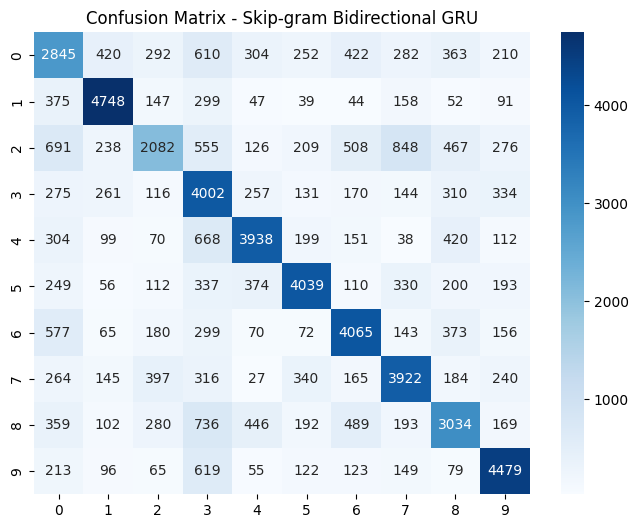

22461

In [56]:
# Cell 40: Skip-gram + Bidirectional GRU
# This cell trains Bidirectional GRU on padded sequences with Skip-gram embeddings.
set_global_policy('mixed_float16')

gru_units = 64
trainable_embedding = False
epochs = 3
batch_size = 16
learning_rate = 0.001
validation_split = 0.1

model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_sg], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding),
    Bidirectional(GRU(gru_units, dtype='float32')),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Skip-gram Bidirectional GRU - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Skip-gram Bidirectional GRU')
plt.show()

# Save model
model.save('/content/drive/MyDrive/CSE440_Project/models/Skipgram_BiGRU.keras')
model.save_weights('/content/drive/MyDrive/CSE440_Project/models/Skipgram_BiGRU.weights.h5')

with open('/content/drive/MyDrive/CSE440_Project/models/history_Skipgram_BiGRU.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('/content/drive/MyDrive/CSE440_Project/models/probs_Skipgram_BiGRU.npy', y_pred_prob)
np.save('/content/drive/MyDrive/CSE440_Project/models/cm_Skipgram_BiGRU.npy', cm)

# Save metrics
results = {'Representation': 'Skip-gram', 'Model': 'Bidirectional GRU', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, history
gc.collect()

Epoch 1/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 99s 12ms/step - accuracy: 0.4691 - loss: 1.5918 - val_accuracy: 0.5814 - val_loss: 1.2903 - learning_rate: 0.0010
Epoch 2/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 94s 12ms/step - accuracy: 0.5985 - loss: 1.2482 - val_accuracy: 0.5939 - val_loss: 1.2406 - learning_rate: 0.0010
Epoch 3/3
7875/7875 ━━━━━━━━━━━━━━━━━━━━ 94s 12ms/step - accuracy: 0.6121 - loss: 1.1930 - val_accuracy: 0.6032 - val_loss: 1.2140 - learning_rate: 0.0010
Skip-gram Bidirectional LSTM - Accuracy: 0.6116, F1 Macro: 0.6082, F1 Weighted: 0.6082
              precision    recall  f1-score   support

           0       0.46      0.48      0.47      6000
           1       0.73      0.81      0.76      6000
           2       0.51      0.37      0.43      6000
           3       0.51      0.61      0.56      6000
           4       0.60      0.73      0.66      5999
           5       0.65      0.72      0.68      6000
           6       0.68      0.63      0.65      6000
           7   

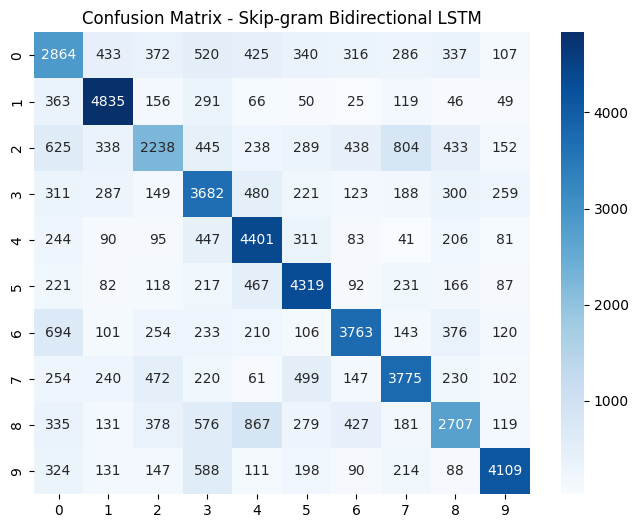

19231

In [57]:
# Cell 41: Skip-gram + Bidirectional LSTM
# This cell trains Bidirectional LSTM on padded sequences with Skip-gram embeddings.
set_global_policy('mixed_float16')

lstm_units = 64
trainable_embedding = False
epochs = 3
batch_size = 16
learning_rate = 0.001
validation_split = 0.1

model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix_sg], input_length=MAX_SEQUENCE_LENGTH, trainable=trainable_embedding),
    Bidirectional(LSTM(lstm_units, dtype='float32')),
    Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)

with tf.device('/GPU:0'):
    history = model.fit(X_pad_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                        callbacks=[early_stopping, lr_scheduler], verbose=1)

with tf.device('/GPU:0'):
    y_pred_prob = model.predict(X_pad_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Skip-gram Bidirectional LSTM - Accuracy: {acc:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Skip-gram Bidirectional LSTM')
plt.show()

# Save model
model.save('/content/drive/MyDrive/CSE440_Project/models/Skipgram_BiLSTM.keras')
model.save_weights('/content/drive/MyDrive/CSE440_Project/models/Skipgram_BiLSTM.weights.h5')

with open('/content/drive/MyDrive/CSE440_Project/models/history_Skipgram_BiLSTM.pkl', 'wb') as f:
    pickle.dump(history.history, f)

np.save('/content/drive/MyDrive/CSE440_Project/models/probs_Skipgram_BiLSTM.npy', y_pred_prob)
np.save('/content/drive/MyDrive/CSE440_Project/models/cm_Skipgram_BiLSTM.npy', cm)

# Save metrics
results = {'Representation': 'Skip-gram', 'Model': 'Bidirectional LSTM', 'Accuracy': acc, 'F1_Macro': f1_macro, 'F1_Weighted': f1_weighted}
pd.DataFrame([results]).to_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv', mode='a', header=False, index=False)

del model, y_pred_prob, y_pred, history
gc.collect()

# **Summary**

Model Performance Measures:
Representation                   Model  Accuracy  F1_Macro  F1_Weighted
           BoW           Random Forest  0.480275  0.470917     0.470915
           BoW     Logistic Regression  0.612194  0.608654     0.608653
           BoW             Naive Bayes  0.602027  0.600802     0.600801
           BoW     Deep Neural Network  0.623077  0.621493     0.621492
        TF-IDF           Random Forest  0.480191  0.468158     0.468156
        TF-IDF     Logistic Regression  0.637444  0.634137     0.634136
        TF-IDF             Naive Bayes  0.621244  0.617439     0.617438
        TF-IDF     Deep Neural Network  0.635111  0.630546     0.630545
         GloVe     Deep Neural Network  0.661894  0.651915     0.651915
         GloVe               SimpleRNN  0.274588  0.247607     0.247606
         GloVe                     GRU  0.642094  0.636558     0.636557
         GloVe                    LSTM  0.629977  0.627068     0.627067
         GloVe Bidirectional SimpleR

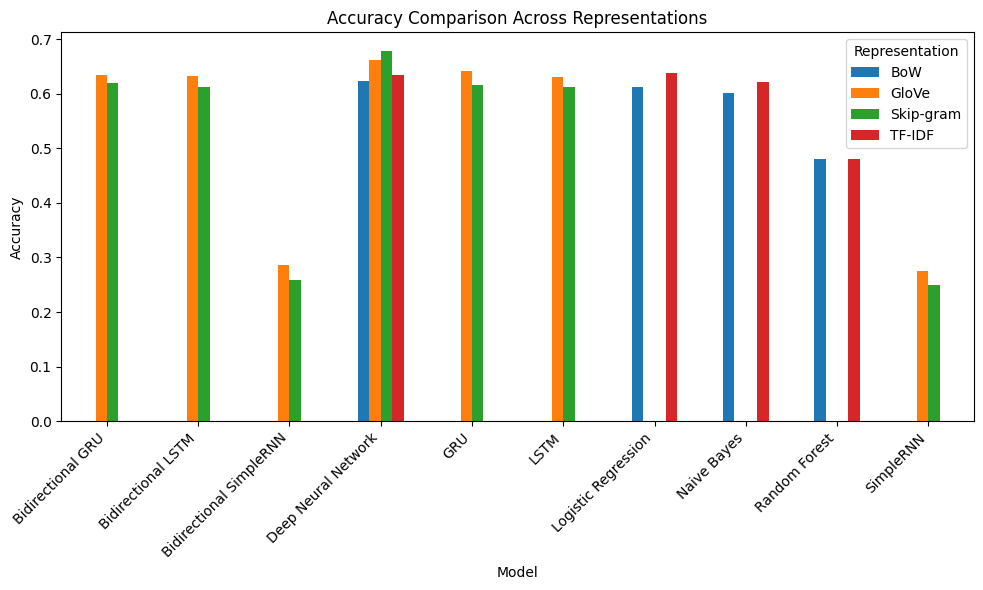

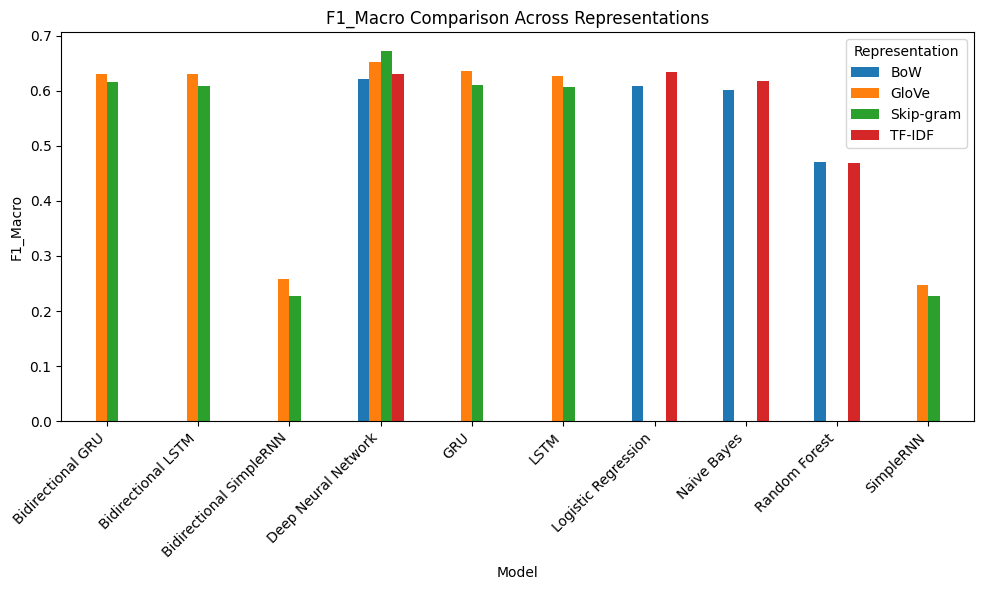

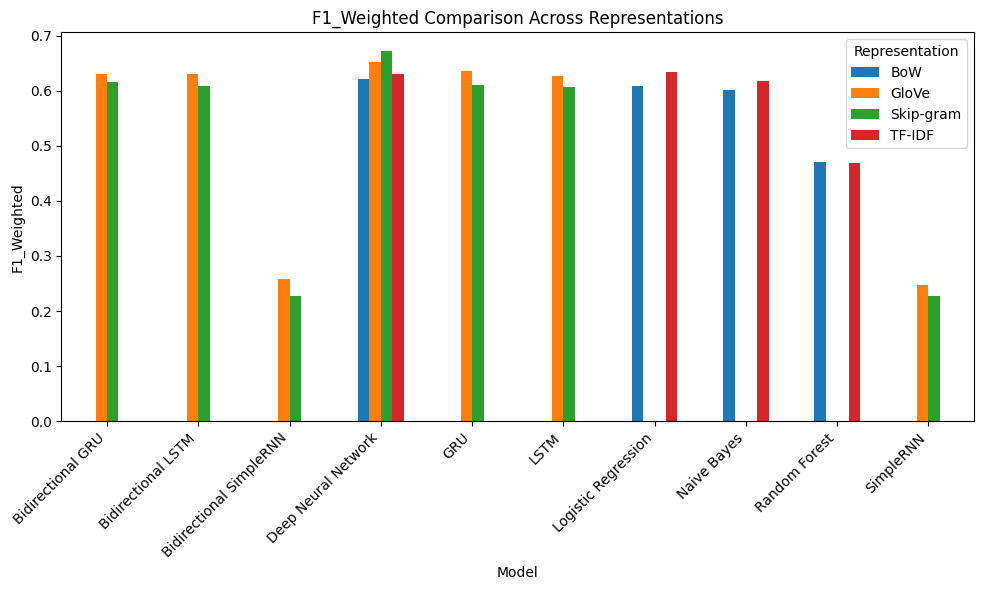

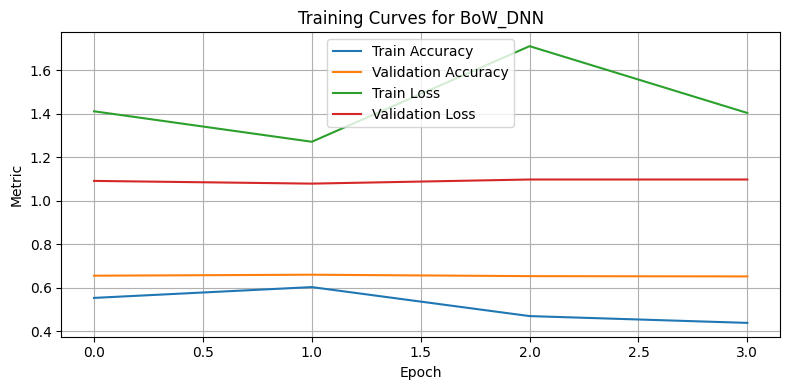

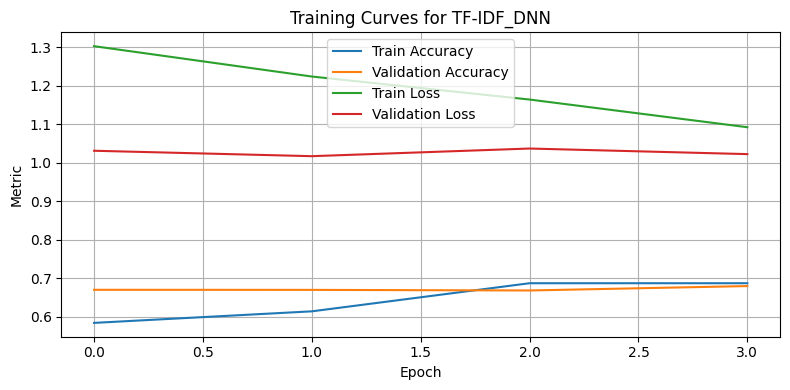

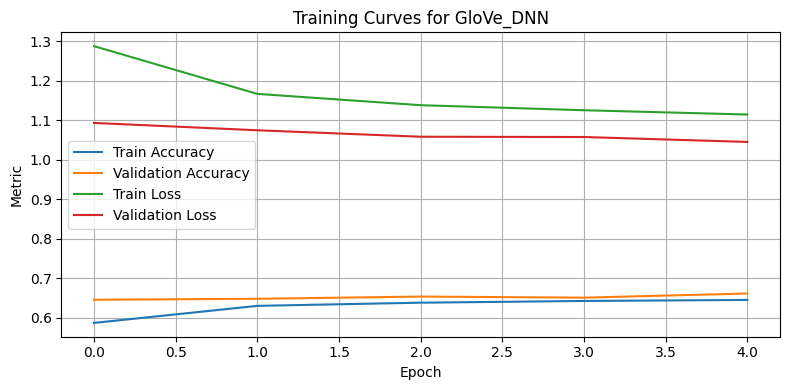

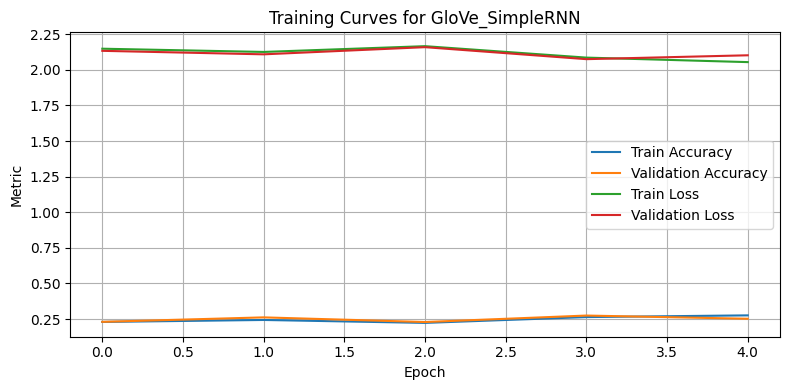

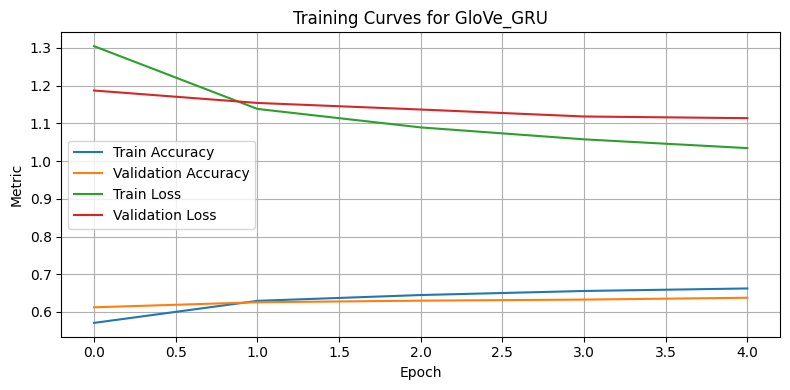

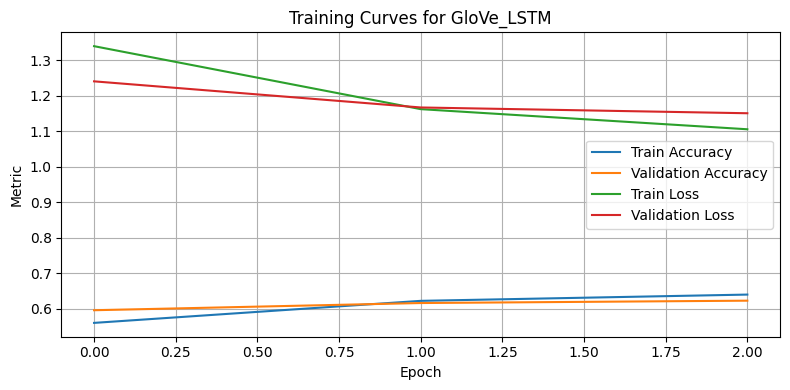

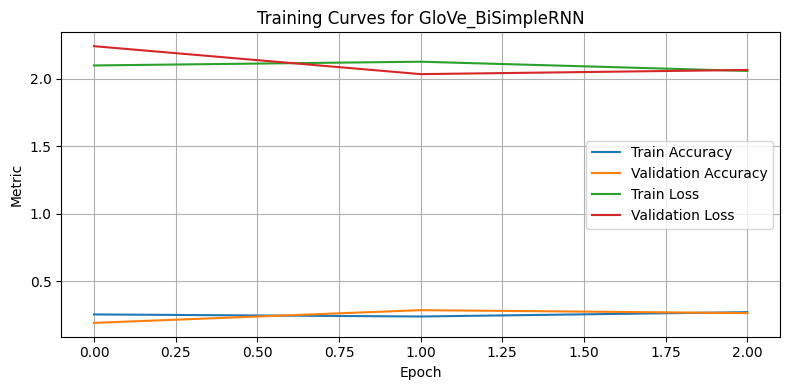

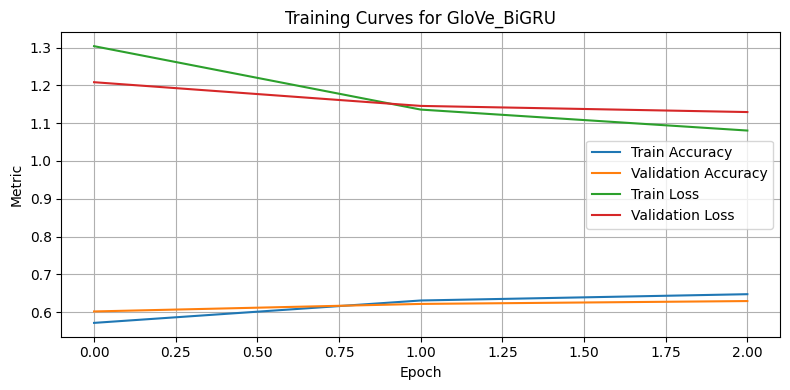

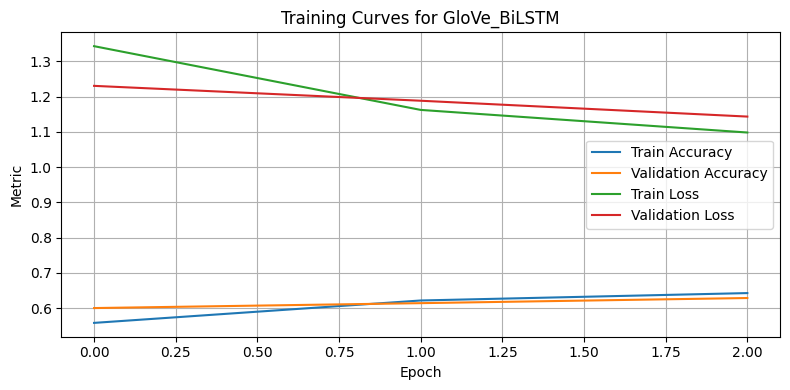

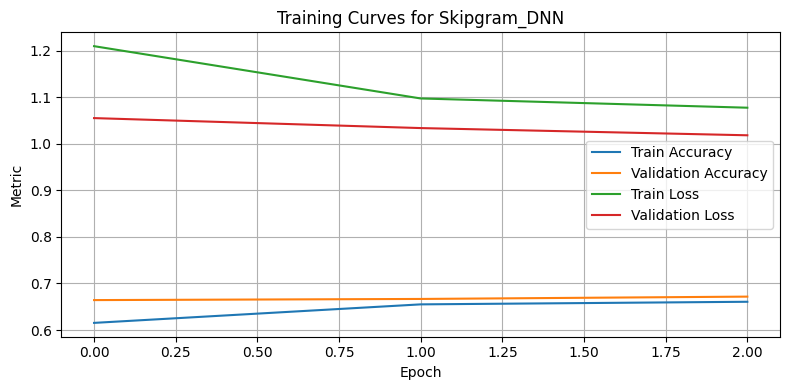

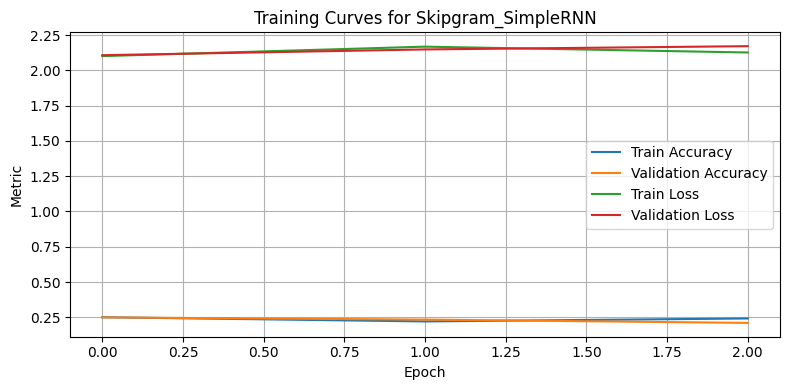

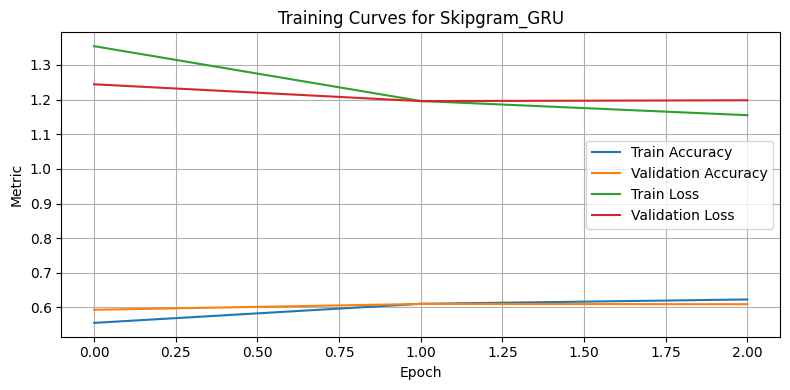

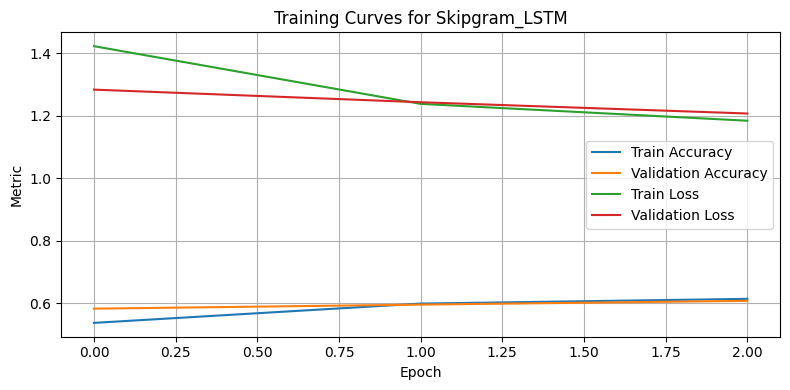

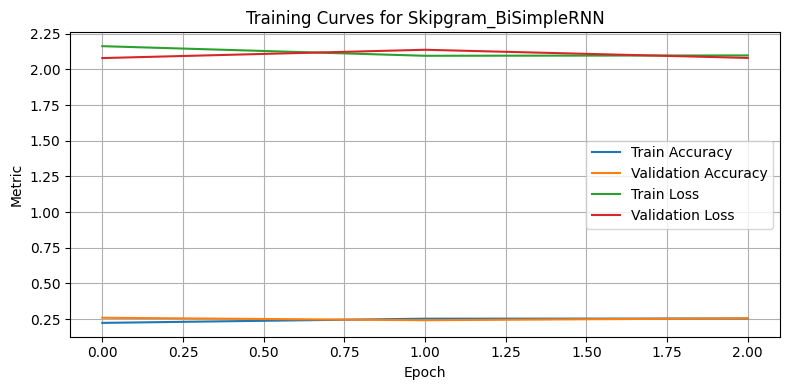

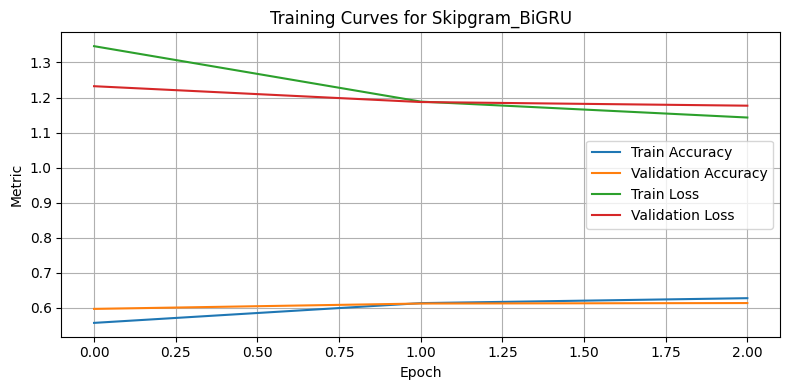

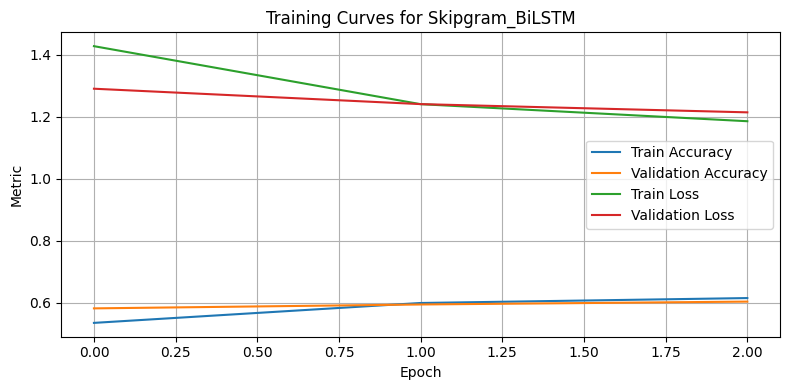

Model comparison visualizations completed.


0

In [59]:
# Cell 42: Model Performance Visualization and Comparison
# This cell loads saved metrics and generates plots for comparison, fixing column name issue.
results_df = pd.read_csv('/content/drive/MyDrive/CSE440_Project/models/model_results.csv',
                        names=['Representation', 'Model', 'Accuracy', 'F1_Macro', 'F1_Weighted'])
print("Model Performance Measures:")
print(results_df.to_string(index=False))

metrics = ['Accuracy', 'F1_Macro', 'F1_Weighted']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    pivot = results_df.pivot(index='Model', columns='Representation', values=metric)
    pivot.plot(kind='bar', ax=plt.gca())
    plt.title(f'{metric} Comparison Across Representations')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Representation')
    plt.tight_layout()
    plt.show()
    plt.close()

# Load and plot training history if available
history_files = os.listdir('/content/drive/MyDrive/CSE440_Project/models/')
history_files = [f for f in history_files if f.startswith('history_') and f.endswith('.pkl')]

if history_files:
    for hist_file in history_files:
        with open(f'/content/drive/MyDrive/CSE440_Project/models/{hist_file}', 'rb') as f:
            history = pickle.load(f)
        model_name = hist_file.replace('history_', '').replace('.pkl', '')
        plt.figure(figsize=(8, 4))
        plt.plot(history['accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title(f'Training Curves for {model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Metric')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.close()
        del history
        gc.collect()

# Confusion matrices
cm_files = [f for f in history_files if f.startswith('cm_') and f.endswith('.npy')]  # Fixed file filter
if cm_files:
    for cm_file in cm_files:
        cm = np.load(f'/content/drive/MyDrive/CSE440_Project/models/{cm_file}')
        model_name = cm_file.replace('cm_', '').replace('.npy', '')
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
        plt.close()
        del cm
        gc.collect()

print("Model comparison visualizations completed.")
gc.collect()